In [1]:
import uproot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import mplhep as hep
plt.style.use([hep.style.ROOT])
from cycler import cycler

import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

In [2]:
model = 'fgsm-0_1'
path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/systPlots_2023/output_2017_PFNano_central'
log_path = f'/nfs/dust/cms/user/hschonen/DataMC/StackPlotter_logs'
save_dir='/afs/desy.de/user/h/hschonen/Plots'
#save_dir = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/Plots'
# edit name of the StackPlotter job
log_id = '12416199'
# indices of log files: ['DY_m', 'Wc_m', 'TT_semim']
log_indices = [4,0,2]

model_labels = {
    'nominal': 'DeepJet (Nominal Training)',
    'fgsm-0_025': 'DeepJet (FGSM $\epsilon=0.025$ Training)',
    'fgsm-0_05': 'DeepJet (FGSM $\epsilon=0.05$ Training)',
    'fgsm-0_075': 'DeepJet (FGSM $\epsilon=0.075$ Training)',
    'fgsm-0_1': 'DeepJet (FGSM $\epsilon=0.1$ Training)',
    'fgsm-0_125': 'DeepJet (FGSM $\epsilon=0.125$ Training)',
    'fgsm-0_15': 'DeepJet (FGSM $\epsilon=0.15$ Training)',
}

model_colors = {
    'nominal': 'black',
    'fgsm-0_025': 'blue',
    'fgsm-0_05': 'green',
    'fgsm-0_075': 'gold',
    'fgsm-0_1': 'orange',
    'fgsm-0_125': 'red',
    'fgsm-0_15': 'darkred',
}

model_epsilons = {
    'nominal': 0,
    'fgsm-0_025': 0.025,
    'fgsm-0_05': 0.05,
    'fgsm-0_075': 0.075,
    'fgsm-0_1': 0.1,
    'fgsm-0_125': 0.125,
    'fgsm-0_15': 0.15,
}

jet_index = {
    'DY_m': '0',
    'Wc_m': 'muJet_idx',
    'TT_semim': 'muJet_idx',
}

In [3]:
# calculate Kullack-Leibler divergence
def kldiv(A, B):
        return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])

# calculate Jensen-Shannon divergence
def jsdiv(P, Q, normalize_first=False):
    P = np.array(P)
    Q = np.array(Q)
    if normalize_first:
        P = P/P.sum()
        Q = Q/Q.sum()
    M = 0.5 * (P + Q)
    return 0.5 * (kldiv(P, M) +kldiv(Q, M))

# get Data/MC normalization factors from logfile (not required for anything done in this script)
def get_normalization_factors():
    factors_dict = {}
    for i,sel in enumerate(['DY_m', 'Wc_m', 'TT_semim']):
        log_file = f'{log_path}/log-{log_id}.{log_indices[i]}.out'
        with open(log_file, 'r') as logfile:
            lines = logfile.readlines()
            normalization_factor = float(lines[lines.index('Will normalize total MC to data, with factor:\n') + 1].strip('\n'))
            print(normalization_factor)
            factors_dict[sel] = normalization_factor
    return factors_dict

normalization_factors = get_normalization_factors()

1.07928553693
1.12502367393
0.763007346831


In [26]:
# function to plot a stack histogram
def plotStack(tagger, selection, disc):
    # Set the correct paths
    if tagger=='nominal':
        # nominal outputs are saved in this directory
        path = f'/nfs/dust/cms/user/hschonen/DataMC/fgsm-0_1/systPlots_2023/output_2017_PFNano_central'
    else:
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{tagger}/systPlots_2023/output_2017_PFNano_central'
    # choose the correct jet indexing
    indexjet = jet_index[selection]
    # choose selection text
    region_text = r'$\bf{DY + jet}$' if selection == 'DY_m' else (r'$\bf{t\bar{t}}$' if selection == 'TT_semim' else r'$\bf{W + c}$')
    # open histogram ROOT files
    if tagger=='nominal':
        histo = uproot.open(f'{path}/{selection}_jet_Custom{disc}_{indexjet}_.root')
    else:
        histo = uproot.open(f'{path}/{selection}_jet_CustomADV{disc}_{indexjet}_.root')
    #print(histo.keys())
    
    # set binning (must match to binning in StackPlotter)
    bins = np.linspace(-0.2,1., 31)
    #print(bins)
    
    # Colours depending on sample, created with the help of coolors.co
    colours = {'W + b jets' : '#BCFDFD', 'W + c jets' : '#00FFFF', 'W + udsg jets' : '#007474', 'W + lep' : '#0D98BA', 
               'DY + b jets' : '#E2E29B', 'DY + c jets' : '#FFFF00', 'DY + udsg jets' : '#5F7A33', 'DY + lep' : '#939E7A',
               r'$t\bar{t}$ (b jets)' : '#FFBCD9', r'$t\bar{t}$ (c jets)' : '#FC0FC0', r'$t\bar{t}$ (udsg jets)' : '#8B008B', r'$t\bar{t}$ (lep)' : '#86608E',
               'ST (b jets)' : '#73A9FA', 'ST (c jets)' : '#0000FF', 'ST (udsg jets)' : '#002366', 'ST (lep)' : '#126180',
               'Bottom' : '#BB0A21', 'Charm' : '#FF9505', 'udsg' : '#4C2882', 'lep' : '#252627'}
    colours = {'W + b jets' : '#FFB5B5', 'W + c jets' : '#97B5FC', 'W + udsg jets' : '#FFFF88', 'W + lep' : '#83FF83', 
               'DY + b jets' : '#FF6F66', 'DY + c jets' : '#4778FF', 'DY + udsg jets' : '#FFFF00', 'DY + lep' : '#00FF00',
               r'$t\bar{t}$ (b jets)' : '#C12929', r'$t\bar{t}$ (c jets)' : '#0000D3', r'$t\bar{t}$ (udsg jets)' : '#BDBD00', r'$t\bar{t}$ (lep)' : '#0F9A0F',
               'ST (b jets)' : '#7F1414', 'ST (c jets)' : '#10108E', 'ST (udsg jets)' : '#8B7B0C', 'ST (lep)' : '#1D651D',
               'Bottom' : '#FF0000', 'Charm' : '#0000FF', 'udsg' : '#ECEC00', 'lep' : '#00C600'}
    
    # Load individual histograms depending on selection
    DYJets_b = histo['DYJets_b'].values()
    DYJets_c = histo['DYJets_c'].values()
    DYJets_uds = histo['DYJets_uds'].values()
    DYJets_lep = histo['DYJets_lep'].values()
    if selection != 'DY_m': # Wc_m and TT_semim
        WJets_b = histo['WJets_b'].values()
        WJets_c = histo['WJets_c'].values()
        WJets_uds = histo['WJets_uds'].values()
        WJets_lep = histo['WJets_lep'].values()
        ttbar_b = histo['ttbar_b'].values()
        ttbar_c = histo['ttbar_c'].values()
        ttbar_uds = histo['ttbar_uds'].values()
        ttbar_lep = histo['ttbar_lep'].values()
        ST_b = histo['ST_b'].values()
        ST_c = histo['ST_c'].values()
        ST_uds = histo['ST_uds'].values()
        ST_lep = histo['ST_lep'].values()
        in_stack_legend = ['W + b jets', 'W + c jets', 'W + udsg jets', 'W + lep', 
                           'DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep', 
                           r'$t\bar{t}$ (b jets)', r'$t\bar{t}$ (c jets)', r'$t\bar{t}$ (udsg jets)', r'$t\bar{t}$ (lep)',
                           'ST (b jets)', 'ST (c jets)', 'ST (udsg jets)', 'ST (lep)']
        in_stack_histos = [WJets_b, WJets_c, WJets_uds, WJets_lep,
                           DYJets_b, DYJets_c, DYJets_uds, DYJets_lep,
                           ttbar_b, ttbar_c, ttbar_uds, ttbar_lep,
                           ST_b, ST_c, ST_uds, ST_lep]
    else: # DY_m
        in_stack_legend = ['DY + b jets', 'DY + c jets', 'DY + udsg jets', 'DY + lep']
        in_stack_histos = [DYJets_b, DYJets_c, DYJets_uds, DYJets_lep]
    # reverse order of list elements
    in_stack_legend.reverse()
    in_stack_histos.reverse()
    # sum of MC samples
    mcsum = histo['MCSum'].values()
    mcsum_err = histo['MCSum'].errors()
    # data sample
    data = histo['Data'].values()
    data_err = histo['Data'].errors()
    
    # calculate JS divergence
    Data = histo['Data'].values()
    MCsum = histo['MCSum'].values()
    MCsum[(MCsum==0)&(Data!=0)] = 0.00001
    negative_values = (Data<0) | (MCsum<0)
    Data[negative_values] = 0
    MCsum[negative_values] = 0 
    js_value = jsdiv(Data, MCsum, normalize_first=True)
    
    # graphic settings
    colors = [colours[name] for name in in_stack_legend] + ['#000000']
    plt.rcParams['axes.axisbelow'] = True
    mpl.rcParams["axes.prop_cycle"] = cycler('color', colors)
    
    # create figure
    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={"height_ratios": (3, 1), 'hspace': 0.0}, sharex=True)
    fig.tight_layout()
    # MC histograms
    hep.histplot(in_stack_histos,
                 bins,
                 label=in_stack_legend, stack=True, histtype='fill',
                 xerr = True, ax=ax1,
                 )
    # data histogram
    hep.histplot(data, bins, label='Data', histtype='errorbar', ax=ax1, xerr=True, yerr=np.sqrt(data))
    n_cols_legend = 4
    leg = ax1.legend(loc="upper left",ncol=n_cols_legend,labels=in_stack_legend+['Data'],fontsize=22,
               bbox_to_anchor=(0., 0.95),
               bbox_transform=ax1.transAxes)
    
    # set labels for the upper plot
    if selection == 'Wc_m':
        yText = 'Jet yield, OS-SS subtracted'
    else:
        yText = 'Jet yield'
    ax1.set_ylabel(yText)
    ax1.set_xlabel('')
    # set text elements
    region_text = r'$\bf{DY + jet}$' if selection == 'DY_m' else (r'$\bf{t\bar{t}}$' if selection == 'TT_semim' else r'$\bf{W + c}$')
    at = AnchoredText(region_text,
                      loc='upper left',frameon=False, prop=dict(size=22),
                     )
    ax1.add_artist(at)
    at2 = AnchoredText(r'$\mu$ channel',
                      loc='upper right',frameon=False, prop=dict(size=22),
                     )
    ax1.add_artist(at2)
    at3 = AnchoredText('$\it{Pre-Calibration}$',
                      loc='upper center',frameon=False, prop=dict(size=22),
                     )
    ax1.add_artist(at3)
    # Overlay an uncertainty hatch
    sumw = np.sum([i_histo for i_histo in in_stack_histos], axis=0)
    sumw2 = np.sum([i_histo**2 for i_histo in in_stack_histos], axis=0)
    unc = mcsum_err
    unc = np.hstack([unc, unc[-1]])
    sumw_total = np.hstack([mcsum, mcsum[-1]])
    num_err = np.sqrt(data)
    denom_err = np.sqrt(mcsum)
    # plot MC errors
    hatch_style = {
        'facecolor': 'none',
        'edgecolor': (0, 0, 0, 0.5),
        'linewidth': 0,
        'hatch': '///',
    }
    ax1.fill_between(x=bins, y1=sumw_total - unc, y2=sumw_total + unc,
                    label='MC stat. unc.', step='post', **hatch_style
                   )
    
    # Data/MC subplot
    # plot Data/MC errors
    ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
    ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')
    ax2.plot([-0.2,1.],[1,1],color='red')
    # set 
    ax2.set_ylim(0.55,1.5)
    ax2.set_xlim(-0.2,1)
    # set ylabel and xlabel
    ax2.set_ylabel('Data/MC', loc='center')
    xText = f'{model_labels[tagger]} {disc}'
    ax2.set_xlabel(xText)
    ax2.set_yticks([0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])
    ax1.plot([])
    ax1.ticklabel_format(axis='y', useMathText=True, scilimits=(0,0))
    hep.cms.label("Preliminary", data=True, lumi=41.5, year=2017,ax=ax1)
    hep.mpl_magic(ax = ax1)
    ax2.grid(which='major', axis='y', alpha=0.95, color='black')
    
    # Legend
    # get handles
    handles, labels = ax1.get_legend_handles_labels()
    handles.reverse()
    labels.reverse()
    handles.append(handles[1])
    handles.pop(1)
    labels.append(labels[1])
    labels.pop(1)
    handles.append(handles[0])
    handles.pop(0)
    labels.append(labels[0])
    labels.pop(0)
    n_cols_legend = 4
    # create legend
    ax1.legend(flip(handles, n_cols_legend),
               flip(labels, n_cols_legend),
               title = 'JS={:.6f}'.format(js_value),
               loc="upper left",ncol=n_cols_legend,fontsize=22, handletextpad=0.5, columnspacing=1.0,
               bbox_to_anchor=(0., 0.95),
               bbox_transform=ax1.transAxes)
    hep.mpl_magic(ax = ax1)
    fig.savefig(f'{save_dir}/dataMC_{tagger}_{selection}_{disc}.pdf', bbox_inches='tight')

In [27]:
# Plotting the JS divergence values:
def plotJS(js_table, models, selections, discriminators, title='', save_name=''):
    fig,ax = plt.subplots(figsize=[12,12])
    plt.style.use(hep.cms.style.ROOT)
    ax.set_xlim(left=0.,right=10)
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.00001,top=5)
    ax.set_ylabel('JS(data,MC)')
    #ax.set_xlabel('Discriminator')
    ax.grid(which='minor', alpha=0.85)
    ax.grid(which='major', alpha=0.95, color='black')
    # choose arbitrary positions to place the JS values
    x = [1,2,3,4,5,6,7,8,9]
    # set x ticks
    labels = ['DY \n BvsL','DY \n CvsB','DY \n CvsL','Wc \n BvsL','Wc \n CvsB','Wc \n CvsL','TT \n BvsL','TT \n CvsB','TT \n CvsL']
    ax.set_xticks(x,labels)
    for i,model in enumerate(models):
        if model=='nominal':
            ax.plot(x, js_table[i,:], label=model_labels[model], color=model_colors[model], marker='_', linestyle='None')
        else:
            ax.plot(x, js_table[i,:], label=model_labels[model], color=model_colors[model], marker='.', linestyle='None')
    # make legend
    leg = ax.legend(title=title,loc='upper left',ncols=1,fontsize=20,title_fontsize=20,labelspacing=0.7,frameon=True,framealpha=1,facecolor='white')
    leg._legend_box.align = 'left'
    leg.get_frame().set_linewidth(0.0)
    hep.cms.label(llabel='Private Work',rlabel='(13 TeV)')
    fig.savefig(save_dir + f'/JS_values{save_name}.pdf', bbox_inches='tight')
    fig.savefig('JS_values.pdf', bbox_inches='tight')
    
# Plotting the JS divergence values:
def plot_bestJS(js_table, models, selections, discriminators, title='', save_name=''):
    # choose the epsilon with the best JS value
    best_epsilons = []
    best_model_indices = np.argmin(js_table, axis=0)
    for i,index in enumerate(best_model_indices):
        epsilon = model_epsilons[models[index]]
        best_epsilons.append(epsilon)
        
    # weight all epsilon with 1/JS²
    weighted_epsilons = []
    for j in range(len(selections)*len(discriminators)):
        value = 0
        weight = 0
        for i,model in enumerate(models):
            value += model_epsilons[model]*1/js_table[i,j]**2
            weight += 1/js_table[i,j]**2
        weighted_epsilons.append(value/weight)
            
    # find two epsilons with best JS divergence
    first_epsilons = []
    second_epsilons = []
    for j in range(len(selections)*len(discriminators)):
        minimum = np.min(js_table[:,j])
        first_epsilon = model_epsilons
        weight = 0
        for i,model in enumerate(models):
            value += model_epsilons[model]*1/js_table[i,j]**2
            weight += 1/js_table[i,j]**2
        weighted_epsilons.append(value/weight)
    
    fig,ax = plt.subplots(figsize=[12,12])
    plt.style.use(hep.cms.style.ROOT)
    ax.set_xlim(left=0.,right=10)
    ax.set_ylim(bottom=-0.01,top=0.25)
    ax.set_ylabel('model \epsilon')
    #ax.set_xlabel('Discriminator')
    ax.grid(which='minor', alpha=0.85)
    ax.grid(which='major', alpha=0.95, color='black')
    # choose arbitrary positions to place the JS values
    x = [1,2,3,4,5,6,7,8,9]
    # set x ticks
    labels = ['DY \n BvsL','DY \n CvsB','DY \n CvsL','Wc \n BvsL','Wc \n CvsB','Wc \n CvsL','TT \n BvsL','TT \n CvsB','TT \n CvsL']
    ax.set_xticks(x,labels)
    # plot bestepsilon
    ax.plot(x, best_epsilons, label='best JS divergence', color='green', marker='.', linestyle='None')
    # plot the 1/JS² weighted epsilon
    ax.plot(x, weighted_epsilons, label='weighted', color='orange', marker='.', linestyle='None')
    # make legend
    leg = ax.legend(title=title,loc='upper left',ncols=1,fontsize=20,title_fontsize=20,labelspacing=0.7,frameon=True,framealpha=1,facecolor='white')
    leg._legend_box.align = 'left'
    leg.get_frame().set_linewidth(0.0)
    hep.cms.label(llabel='Private Work',rlabel='(13 TeV)')
    fig.savefig(f'{save_dir}/JS_models{save_name}.pdf', bbox_inches='tight')
    fig.savefig('JS_models.pdf', bbox_inches='tight')

In [28]:
# automatic LateX formatting
def JS_Latex(js_table, models, selections, discriminators):
    print('\\begin{table}[h]')
    print('\\label{tab:js_values}')
    print('\\caption{JS divergence values}')
    print('\\resizebox{\\textwidth}{!}{')
    tabular_line = '\\begin{tabular}{|c|'
    header_line = 'model '
    new_line = '\\\\ \\hline '
    for selection in selections:
          for discriminator in discriminators:
                tabular_line = tabular_line + 'c|'
                header_line = header_line + f'& {discriminator} '
                new_line = new_line + '&'
    new_line = new_line + ' \\\\ [-1em]'
    tabular_line = tabular_line + '}'
    header_line = header_line + new_line
    print(tabular_line)
    print('\hline')
    print(header_line)
    for i,model in enumerate(models):
        line = model_labels[model]
        for j in range(len(selections)*len(discriminators)):
            if js_table[i,j]==np.min(js_table[:,j]):
                line = line + ' & $\\textbf{'+'{:.6f}'.format(js_table[i,j])+'}$'
            else:
                line = line + ' & {:.6f}'.format(js_table[i,j])
        line = line + ' ' + new_line
        print(line)
    if include_DPnote:
        print('nominal (DPnote) & 0.000358 & 0.000353 & 0.000947 & 0.002632 & $\\textbf{0.002350}$ & 0.002263 & 0.003506 & $\\textbf{0.002528}$ & 0.004820 \\\\ \\hline &&&&&&&&& \\\\[-1em]')
        print('adversarial (DPnote) & $\\textbf{0.000063}$ & $\\textbf{0.000058}$ & $\\textbf{0.000466}$ & $\\textbf{0.001887}$ & 0.003074 & $\\textbf{0.001766}$ & $\\textbf{0.003329}$ & 0.003005 & $\\textbf{0.002924}$ \\\\ \\hline')
    print('\\end{tabular}}')
    print('\\end{table}')

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00097332 0.00125668 0.00130409 0.00327636 0.00248225 0.00410233
  0.00495643 0.0033532  0.00603225]
 [0.00042134 0.00063952 0.00057761 0.00303507 0.00270442 0.00383033
  0.00519607 0.00469442 0.00493554]
 [0.00049499 0.00073385 0.0007765  0.00273473 0.00281002 0.00341906
  0.0046476  0.00435793 0.00419133]
 [0.00046288 0.00079401 0.00063966 0.00215012 0.00289718 0.00324062
  0.00484745 0.00462951 0.00394568]
 [0.00059299 0.00079696 0.00062263 0.00288692 0.00250177 0.00339289
  0.00496007 0.00450636 0.00474136]
 [0.00024167 0.00079017 0.00027947 0.00250824 0.00217402 0.00244578
  0.0045746  0.00448763 0.0041713 ]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.000973 & 0.001257 & 0.001304 & 0.003276 & 0.002482 & 0.004102 & 0.004956 & $\textbf{0.003353}$ & 0.006

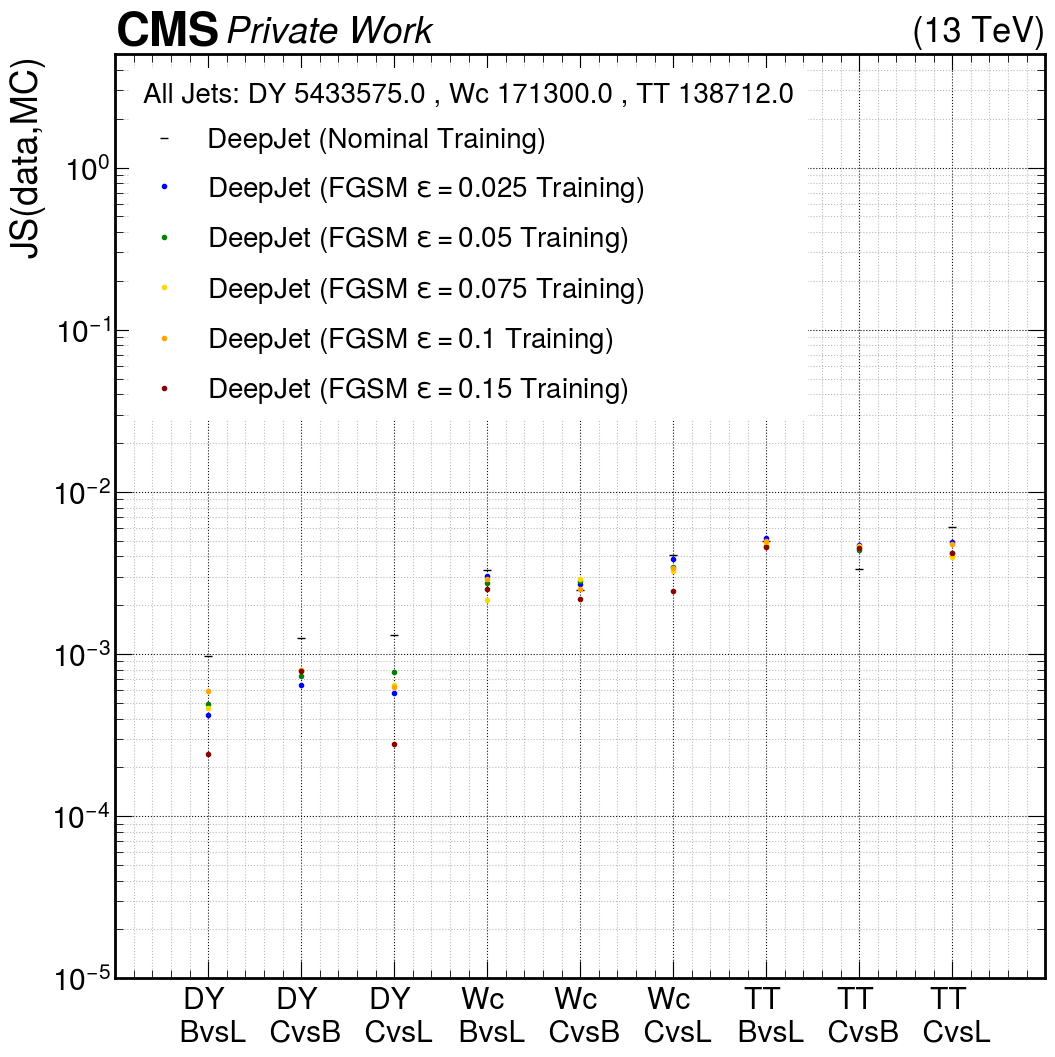

In [34]:
# calculate JS divergence values for all models

models = ['nominal','fgsm-0_025','fgsm-0_05','fgsm-0_075','fgsm-0_1','fgsm-0_15']#]#]
selections = ['DY_m','Wc_m','TT_semim']
discriminators = ['BvsL','CvsB','CvsL']
include_DPnote = True # optional: include JS values from DPnote in LaTeX table?

js_table = np.zeros((len(models),len(selections)*len(discriminators)))
N_selection = []
for i,model in enumerate(models):
    # nominal model is saved in the other directories
    if model=='nominal':
        path = f'/nfs/dust/cms/user/hschonen/DataMC/fgsm-0_1/systPlots_2023/output_2017_PFNano_central' 
        #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' # old models
    else:
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/systPlots_2023/output_2017_PFNano_central'
        #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' #old models
    for j,selection in enumerate(selections):
        for k,discriminator in enumerate(discriminators):
            if model=='nominal':
                histo = uproot.open(f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
                #print('open: ',f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
            else:
                histo = uproot.open(f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
                #print('open: ',f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
            # get Data and MC sum
            data = histo['Data'].values()
            MCsum = histo['MCSum'].values()
            if i==0 and k==0:
                N_selection.append(np.sum(data))
            MCsum[(MCsum==0)&(data!=0)] = 0.00001
            negative_values = (data<0) | (MCsum<0)
            data[negative_values] = 0
            MCsum[negative_values] = 0 
            js_value = jsdiv(data, MCsum, normalize_first=True)
            js_table[i,j*len(discriminators)+k] = js_value
print(js_table)
title = 'All Jets: DY {} , Wc {} , TT {}'.format(N_selection[0],N_selection[1],N_selection[2])
save_name = ''
plotJS(js_table, models, selections, discriminators, title=title, save_name=save_name)
#plot_bestJS(js_table, models, selections, discriminators, title=title, save_name=save_name)
JS_Latex(js_table, models, selections, discriminators)

pt [0,50] , |eta| [0,0.5] , DY_m : data 868851.0 , MC 868851.0000000005
pt [0,50] , |eta| [0,0.5] , Wc_m : data 27456.0 , MC 27455.99999999999


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


pt [0,50] , |eta| [0,0.5] , TT_semim : data 13097.0 , MC 13097.0


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00182152 0.00217585 0.0019586  0.00286286 0.00803893 0.00529216
  0.00605018 0.00459726 0.00726622]
 [0.00091858 0.00101722 0.00123314 0.00378237 0.00888204 0.00734994
  0.0054843  0.00472857 0.0057275 ]
 [0.00114624 0.00124406 0.00150227 0.00546351 0.00494773 0.00551659
  0.00500155 0.00489352 0.00400174]
 [0.00115146 0.00144212 0.00125565 0.00490638 0.00397017 0.00424484
  0.005133   0.00498899 0.00419156]
 [0.00135088 0.0013718  0.00135447 0.00429384 0.00546418 0.00555751
  0.0053015  0.00471256 0.00552589]
 [0.0009609  0.00171691 0.00059856 0.0057562  0.0063159  0.00451963
  0.00444902 0.00445289 0.00396777]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001822 & 0.002176 & 0.001959 & $\textbf{0.002863}$ & 0.008039 & 0.005292 & 0.006050 & 0.004597 & 0.007

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


pt [0,50] , |eta| [0.5,1.25] , TT_semim : data 16619.0 , MC 16619.0


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00153552 0.00183062 0.00167259 0.00882898 0.00417652 0.01007127
  0.00506568 0.00338917 0.00561147]
 [0.00061884 0.00076249 0.00067284 0.00712224 0.00694327 0.01079064
  0.00529621 0.00472788 0.00506026]
 [0.0008271  0.00109122 0.00082478 0.0089841  0.00796221 0.00880815
  0.0048076  0.00408394 0.00489891]
 [0.00088051 0.00121181 0.00081137 0.00604725 0.00686064 0.00602952
  0.00480199 0.00445313 0.00414208]
 [0.00097792 0.00109962 0.00085707 0.0113319  0.00891768 0.00624133
  0.00533753 0.00423607 0.00567246]
 [0.00048211 0.00131642 0.00019571 0.0066019  0.00854309 0.00543528
  0.00489399 0.0044794  0.00423876]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001536 & 0.001831 & 0.001673 & 0.008829 & $\textbf{0.004177}$ & 0.010071 & 0.005066 & $\textbf{0.00338

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00155912 0.00184528 0.00166479 0.00835207 0.00410095 0.0152949
  0.00778344 0.00559048 0.00884298]
 [0.00062761 0.00075955 0.00059465 0.00767257 0.00668514 0.0130231
  0.00777208 0.00845013 0.00748062]
 [0.00101394 0.00146338 0.00077182 0.00661989 0.00601239 0.01011221
  0.00714943 0.00706188 0.00686311]
 [0.00094244 0.00139204 0.00068511 0.00630118 0.00775295 0.01245107
  0.00727586 0.00808297 0.00674766]
 [0.00122733 0.00120736 0.00100131 0.00872958 0.00841164 0.01255407
  0.0077942  0.00726146 0.00741964]
 [0.00025183 0.00114647 0.00045165 0.00813057 0.00798418 0.00561837
  0.00678436 0.00749071 0.00710989]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001559 & 0.001845 & 0.001665 & 0.008352 & $\textbf{0.004101}$ & 0.015295 & 0.007783 & $\textbf{0.005590}

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.0017213  0.0036162  0.00222043 0.01155398 0.01068995 0.0089785
  0.00354169 0.00280012 0.00507689]
 [0.00151523 0.0028673  0.00168232 0.01082452 0.01140479 0.01032618
  0.00423691 0.00394762 0.00436022]
 [0.00138163 0.00268475 0.00241381 0.00689477 0.0085792  0.00818635
  0.0034061  0.00351689 0.00338066]
 [0.00114344 0.00284366 0.00203169 0.00685395 0.01350907 0.00475693
  0.00399751 0.00393755 0.00335504]
 [0.00130339 0.00279628 0.00164514 0.01254787 0.00878179 0.00946403
  0.0037316  0.00364264 0.00368284]
 [0.0010287  0.00315923 0.00146378 0.00685788 0.01120524 0.00852444
  0.00345808 0.00356397 0.00306762]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001721 & 0.003616 & 0.002220 & 0.011554 & 0.010690 & 0.008979 & 0.003542 & $\textbf{0.002800}$ & 0.0050

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00108707 0.00284547 0.00136739 0.00507276 0.00584037 0.0063938
  0.00387011 0.00297682 0.00504451]
 [0.00068079 0.00182972 0.00080746 0.0062191  0.00780312 0.00886691
  0.00405713 0.00379388 0.00400401]
 [0.00067182 0.00196306 0.00123513 0.01041514 0.00476004 0.00668886
  0.00355796 0.00380658 0.00368136]
 [0.00055985 0.00188596 0.00090663 0.00736192 0.00495436 0.00833256
  0.00372594 0.00389906 0.00294171]
 [0.0005675  0.00189401 0.00058535 0.00526982 0.00509643 0.00682577
  0.00386491 0.00385007 0.00399445]
 [0.00039188 0.00202254 0.00045854 0.01161503 0.00480803 0.01083316
  0.00347171 0.00384917 0.00319698]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001087 & 0.002845 & 0.001367 & $\textbf{0.005073}$ & 0.005840 & $\textbf{0.006394}$ & 0.003870 & $\text

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.0013189  0.00278025 0.00182336 0.00670374 0.00592595 0.01277938
  0.00576546 0.00314033 0.00729431]
 [0.00067012 0.0017874  0.00061625 0.01035389 0.01457101 0.0129417
  0.00597871 0.00511551 0.00613784]
 [0.00081777 0.00207204 0.00114078 0.00658874 0.0110448  0.0088012
  0.00554072 0.00485284 0.005606  ]
 [0.00068902 0.00197998 0.00071649 0.00664035 0.01422454 0.00852442
  0.00574821 0.00525486 0.00521583]
 [0.00065586 0.00195561 0.00052888 0.0082128  0.00575539 0.00615997
  0.00611785 0.00504832 0.00604928]
 [0.00023722 0.00162402 0.00056991 0.00989666 0.00958391 0.00485708
  0.00606426 0.00540454 0.00587741]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001319 & 0.002780 & 0.001823 & 0.006704 & 0.005926 & 0.012779 & 0.005765 & $\textbf{0.003140}$ & 0.00729

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00215194 0.00454722 0.00279045 0.03599944 0.03792967 0.04196937
  0.00647207 0.00508915 0.00724249]
 [0.00216516 0.00364964 0.0021978  0.03205146 0.0440027  0.04665458
  0.00667401 0.00555065 0.00557993]
 [0.00178655 0.00353389 0.00212915 0.07191842 0.07024514 0.05003458
  0.00616997 0.0057229  0.00466809]
 [0.00172141 0.00356938 0.00190308 0.10277201 0.05046524 0.0689967
  0.00637617 0.00562505 0.00449595]
 [0.00157521 0.00333406 0.00169471 0.05267657 0.04974031 0.05210457
  0.00666852 0.00557228 0.00477433]
 [0.00166117 0.00363052 0.00185311 0.0929385  0.08149311 0.04776312
  0.00602767 0.00535318 0.00462845]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.002152 & 0.004547 & 0.002790 & 0.035999 & $\textbf{0.037930}$ & $\textbf{0.041969}$ & 0.006472 & $\text

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00134635 0.00358386 0.00145548 0.03924092 0.03978621 0.04986004
  0.00654202 0.00525707 0.00719243]
 [0.00099305 0.00268616 0.00096359 0.07472171 0.07054524 0.04070302
  0.00650795 0.00689272 0.00596557]
 [0.00080852 0.00260298 0.00105141 0.04738887 0.0821007  0.03361798
  0.00683908 0.00652961 0.00569951]
 [0.00068295 0.0024245  0.00085787 0.04310052 0.04282661 0.06468911
  0.00648571 0.00682176 0.00499842]
 [0.00076694 0.00234384 0.00055091 0.0668455  0.05403742 0.05008947
  0.00660031 0.00762337 0.0060961 ]
 [0.0006549  0.00242501 0.00057104 0.03530948 0.02476271 0.0397889
  0.00652709 0.00769375 0.00597612]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001346 & 0.003584 & 0.001455 & 0.039241 & 0.039786 & 0.049860 & 0.006542 & $\textbf{0.005257}$ & 0.0071

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


[[0.00167101 0.00332255 0.00184705 0.05933255 0.052305   0.06251999
  0.0080437  0.00567414 0.00776268]
 [0.00081549 0.00188263 0.00052033 0.02878007 0.04455337 0.04397409
  0.00842164 0.00748369 0.00707131]
 [0.00075554 0.00178045 0.00083631 0.04823769 0.10471065 0.12778418
  0.00729037 0.00729584 0.00572325]
 [0.00068106 0.00167716 0.00067342 0.06881897 0.05195082 0.11200538
  0.00820109 0.00774219 0.00548798]
 [0.0006215  0.00151115 0.0004699  0.07911403 0.03066536 0.08528585
  0.00750309 0.00686861 0.00639944]
 [0.00040983 0.00135498 0.00039758 0.06830397 0.02607389 0.0611096
  0.00763354 0.00675494 0.00687387]]
\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.001671 & 0.003323 & 0.001847 & 0.059333 & 0.052305 & 0.062520 & 0.008044 & $\textbf{0.005674}$ & 0.0077

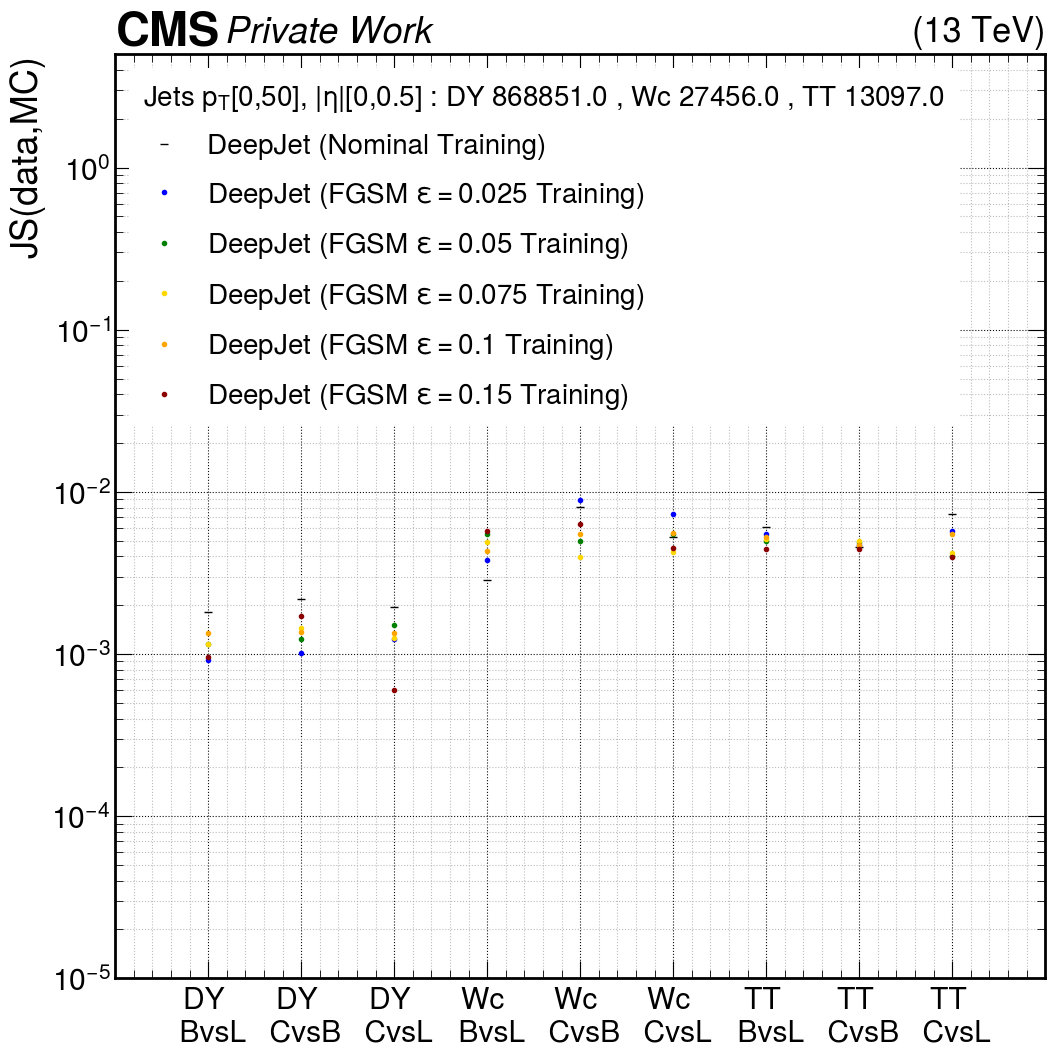

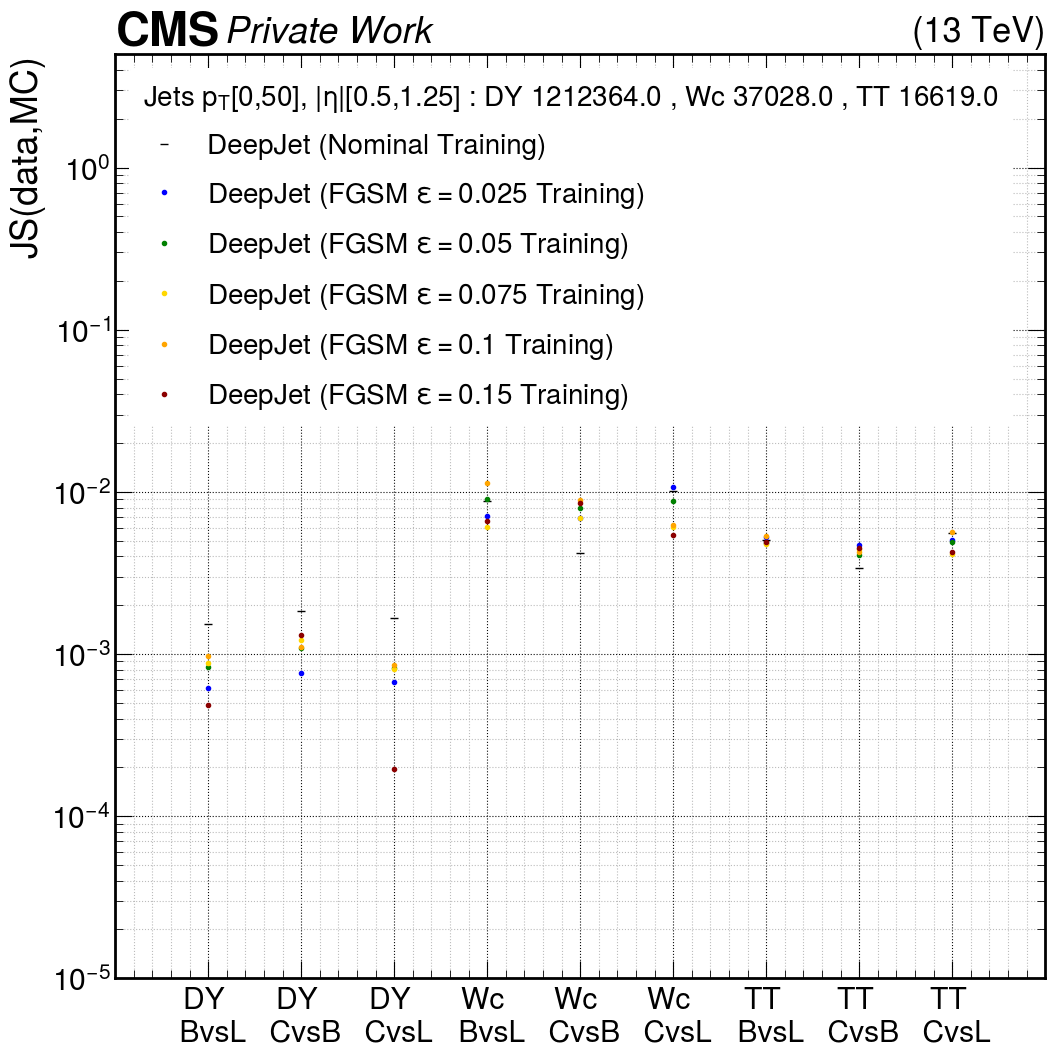

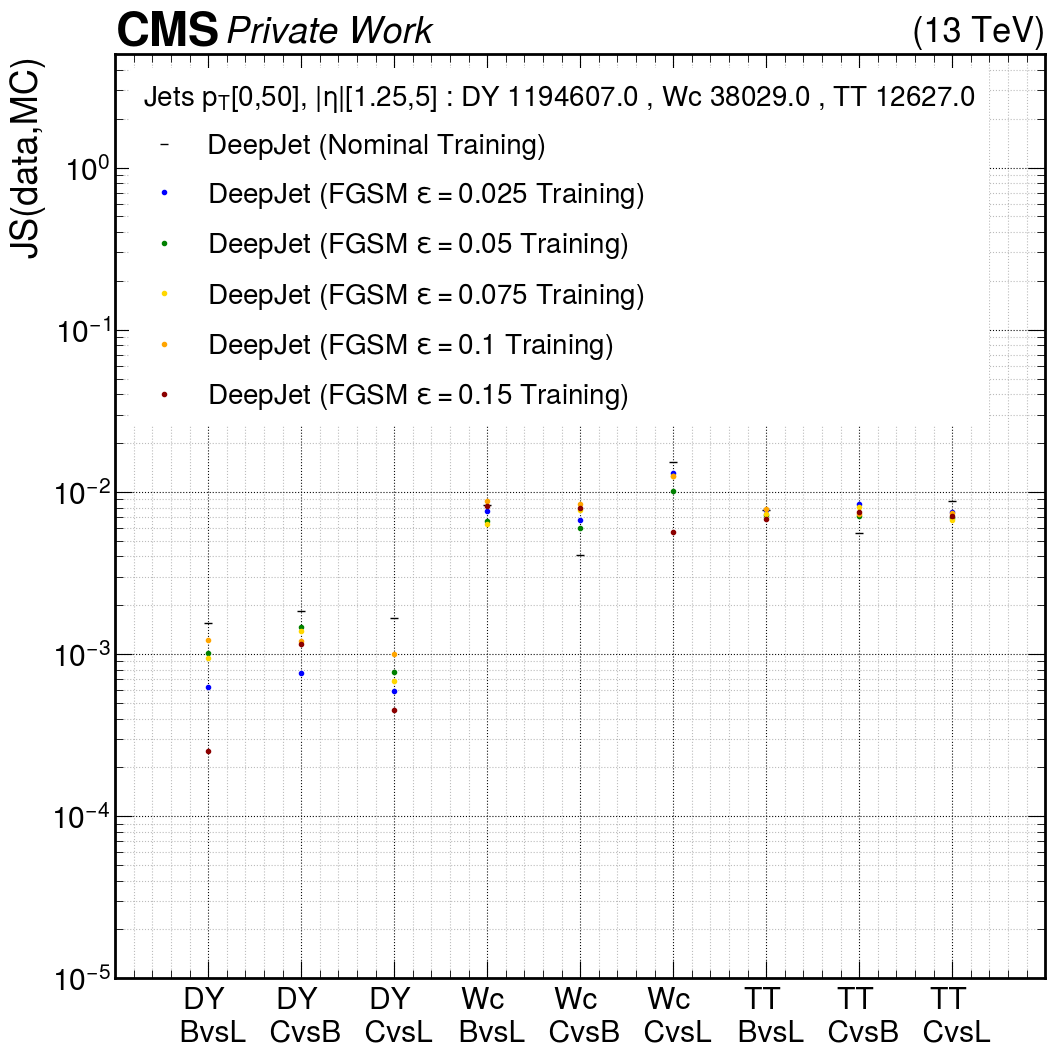

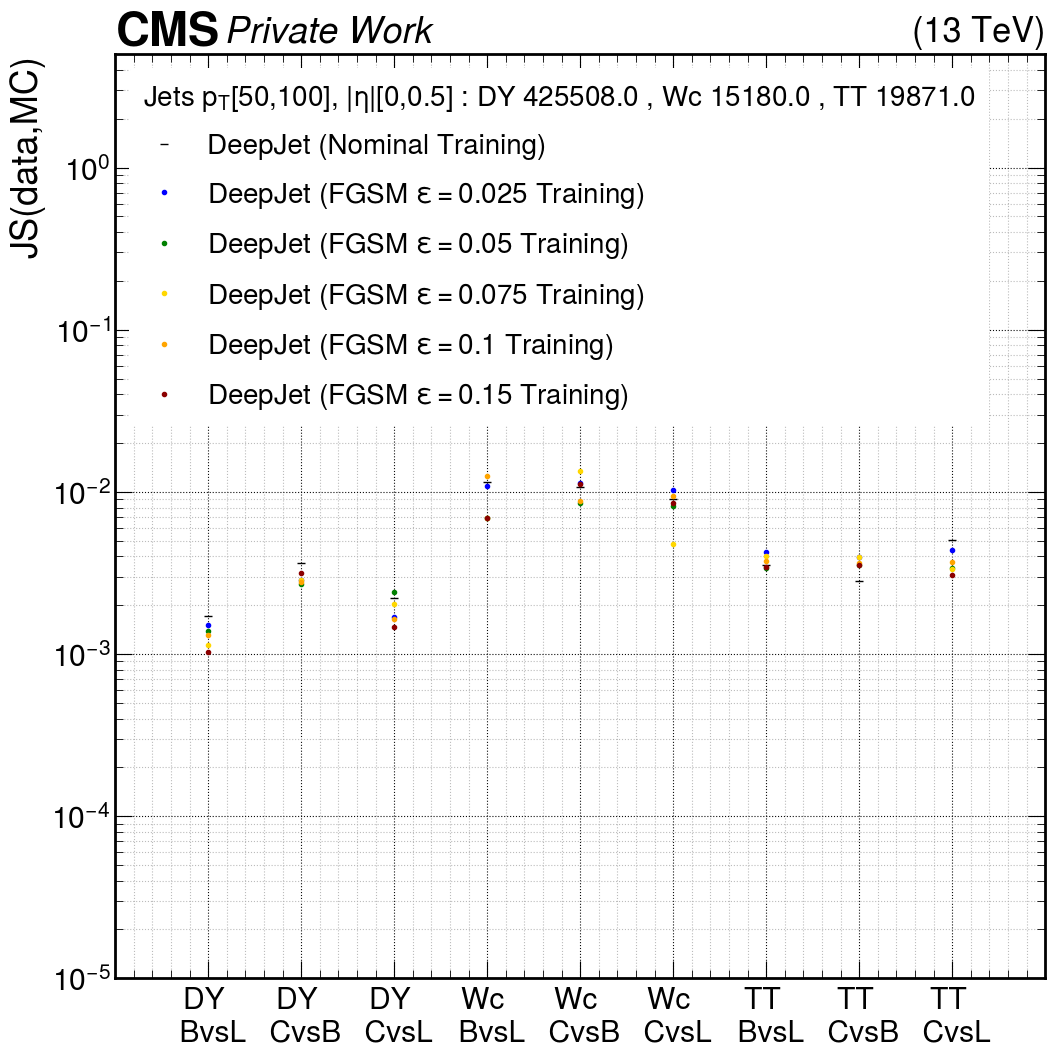

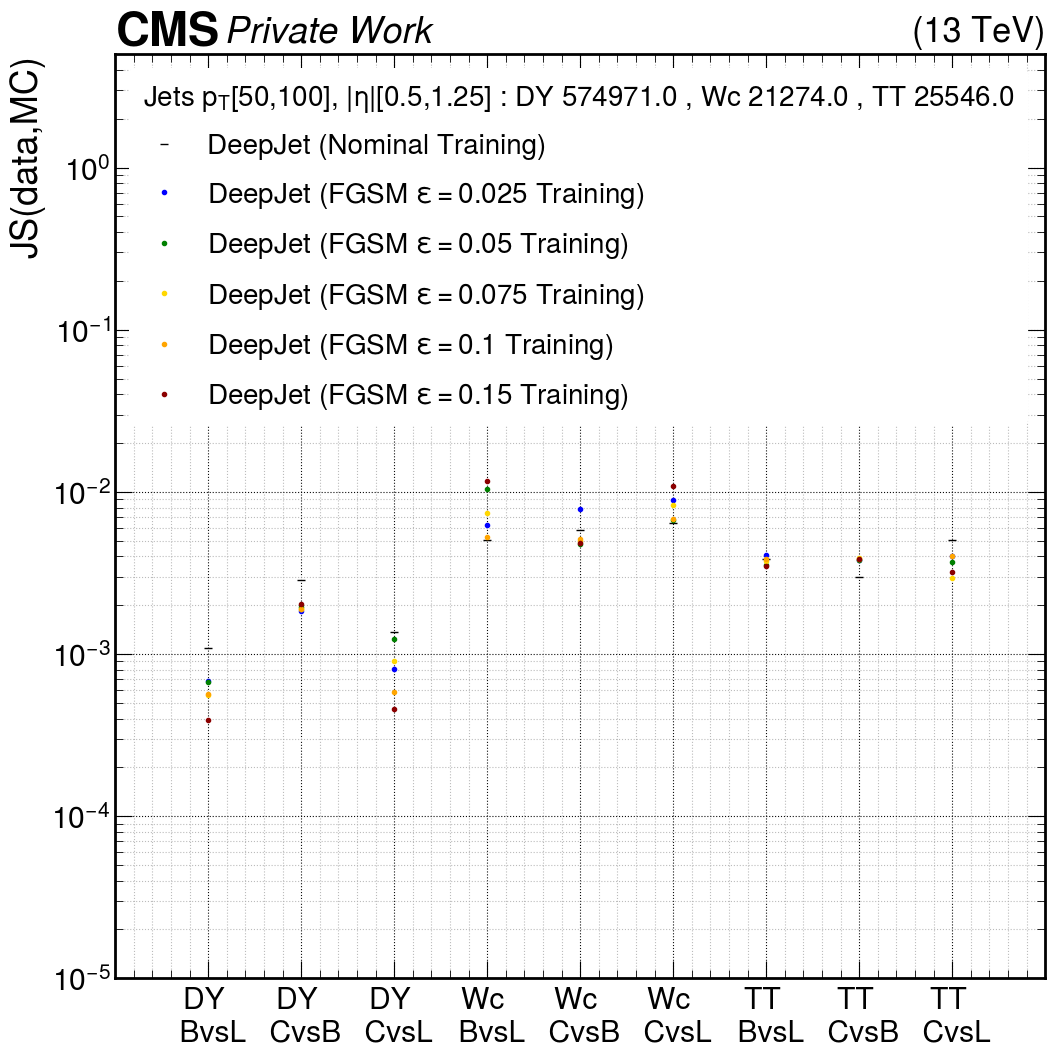

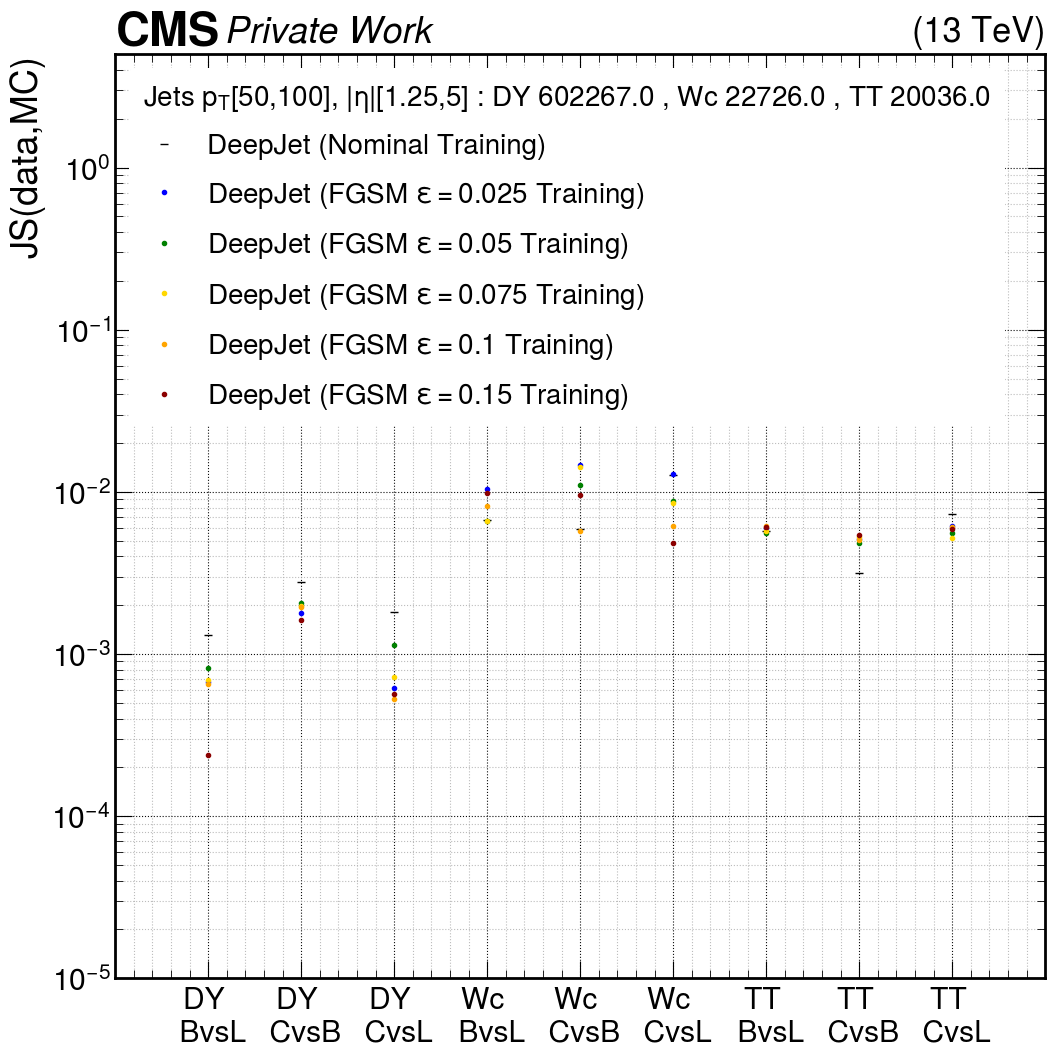

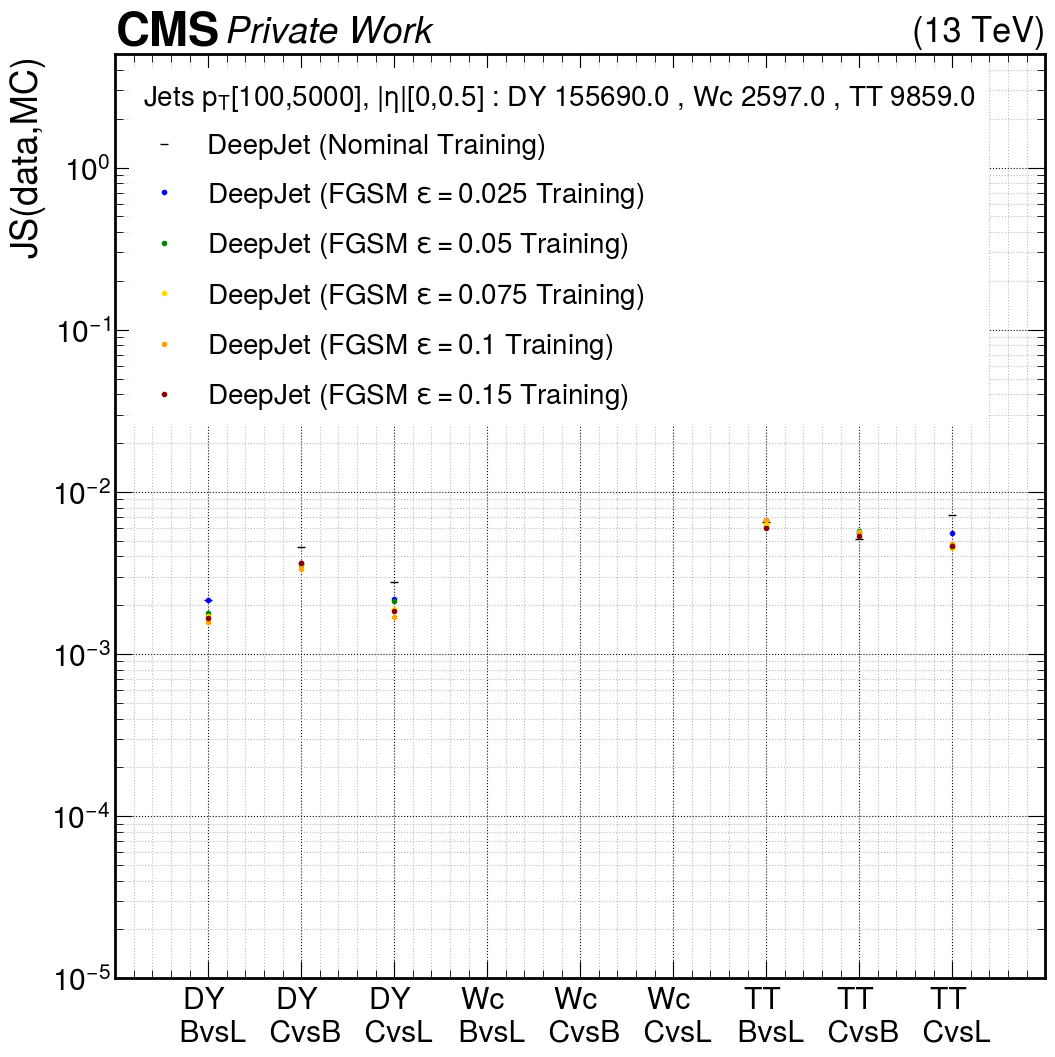

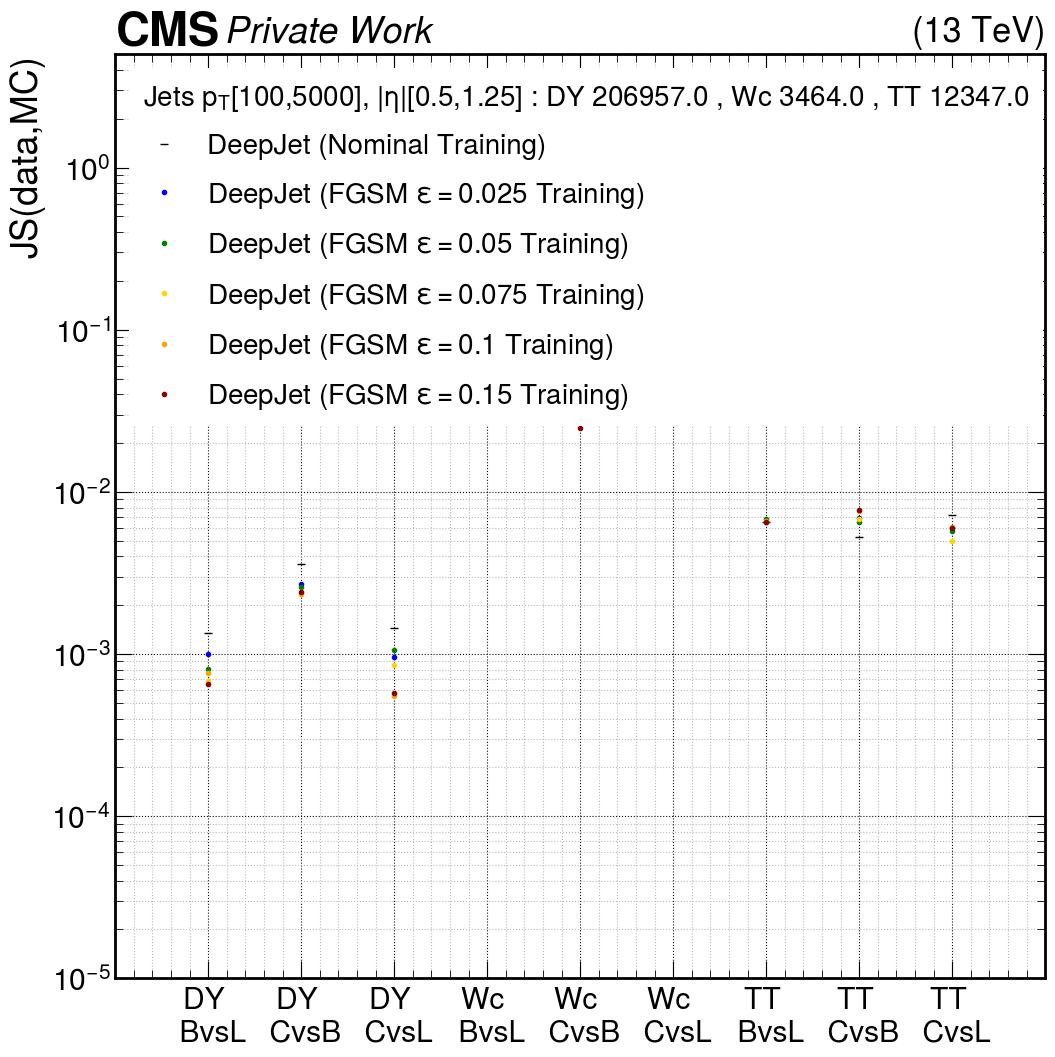

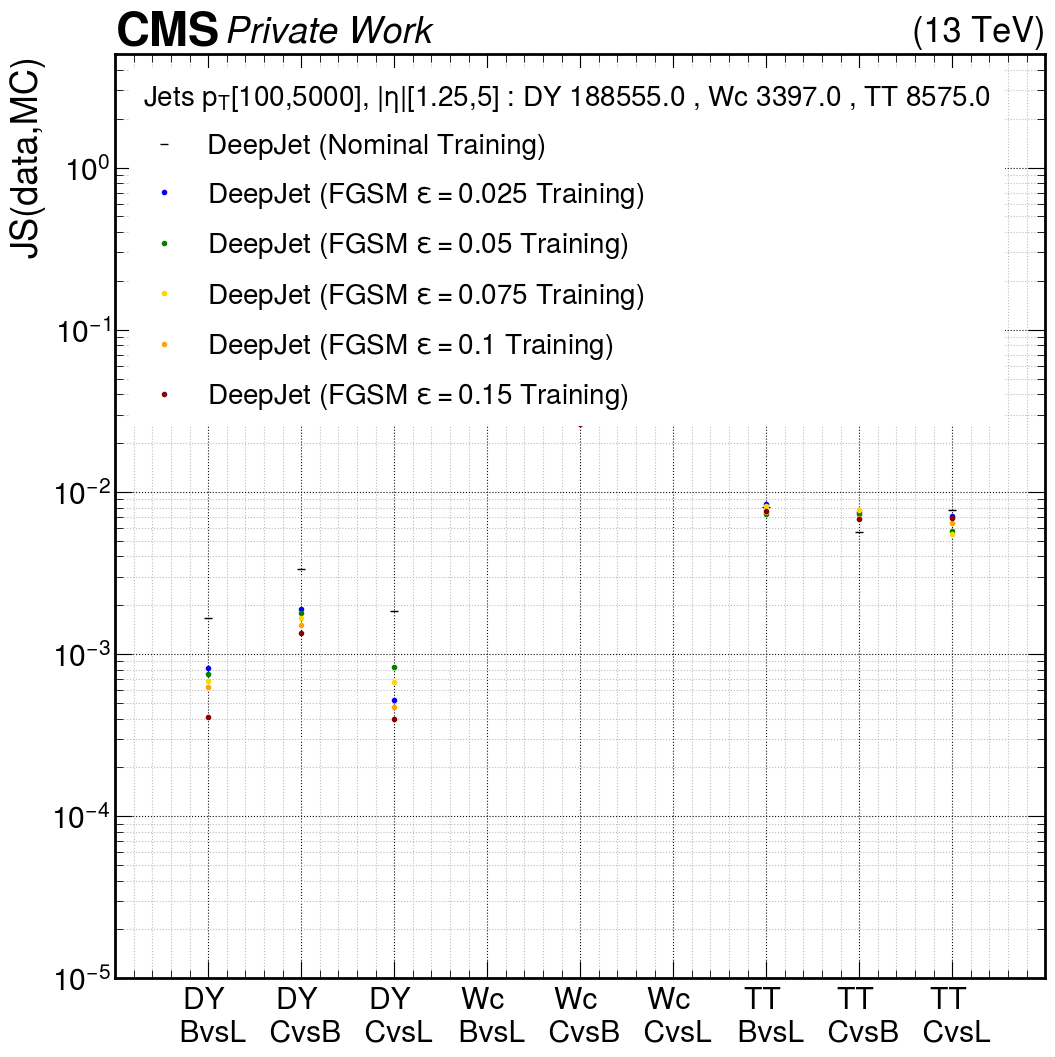

In [33]:
# calculate JS divergence values for all models with (pT,eta) selection

models = ['nominal','fgsm-0_025','fgsm-0_05','fgsm-0_075','fgsm-0_1','fgsm-0_15']
selections = ['DY_m','Wc_m','TT_semim']
discriminators = ['BvsL','CvsB','CvsL']

pt_edges = [0,50,100,5000]
eta_edges = [0,0.5,1.25,5]

include_DPnote = False # optional: include JS values from DPnote in LaTeX table?
for ind_pt in range(len(pt_edges)-1):
    pt_min = pt_edges[ind_pt]
    pt_max = pt_edges[ind_pt+1]
    for ind_eta in range(len(eta_edges)-1):
        eta_min = eta_edges[ind_eta]
        eta_max = eta_edges[ind_eta+1]
        js_table = np.zeros((len(models),len(selections)*len(discriminators)))
        N_selection = []
        for i,model in enumerate(models):
            # nominal model is saved in the other directories
            if model=='nominal':
                path = f'/nfs/dust/cms/user/hschonen/DataMC/fgsm-0_1/systPlots_2023/output_2017_PFNano_central' 
                #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' # old models
            else:
                path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/systPlots_2023/output_2017_PFNano_central'
                #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' #old models
            for j,selection in enumerate(selections):
                for k,discriminator in enumerate(discriminators):
                    if model=='nominal':
                        histo = uproot.open(f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_pt_{pt_min}-{pt_max}_eta_{eta_min}-{eta_max}_'.replace('.','_')+'.root')
                        #print('open: ',f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
                    else:
                        histo = uproot.open(f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_pt_{pt_min}-{pt_max}_eta_{eta_min}-{eta_max}_'.replace('.','_')+'.root')
                        #print('open: ',f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
                    # get Data and MC sum
                    data = histo['Data'].values()
                    MCsum = histo['MCSum'].values()
                    if i==0 and k==0:
                        N_selection.append(np.sum(data))
                        print(f'pt [{pt_min},{pt_max}] , |eta| [{eta_min},{eta_max}] , {selection} : data {np.sum(data)} , MC {np.sum(MCsum)}')
                    MCsum[(MCsum==0)&(data!=0)] = 0.00001
                    negative_values = (data<0) | (MCsum<0)
                    data[negative_values] = 0
                    MCsum[negative_values] = 0 
                    js_value = jsdiv(data, MCsum, normalize_first=True)
                    js_table[i,j*len(discriminators)+k] = js_value
        print(js_table)
        title = 'Jets $p_{T}$'+f'[{pt_min},{pt_max}]'+', $|\eta|$'+f'[{eta_min},{eta_max}]'+' : DY {} , Wc {} , TT {}'.format(N_selection[0],N_selection[1],N_selection[2])
        save_name = f'_pt-{pt_min}-{pt_max}-eta-{eta_min}-{eta_max}'.replace('.','_')
        plotJS(js_table, models, selections, discriminators, title=title, save_name=save_name)
        JS_Latex(js_table, models, selections, discriminators)

/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


/tmp/ipykernel_14091/3322445459.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_14091/3764537425.py:147: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/mcsum)**2 + (data/(mcsum**2) * mcsum_err)**2)
/tmp/ipykernel_14091/3764537425.py:148: RuntimeWarning: invalid value encountered in divide
  ax2.errorbar(bins[:-1] + 0.02,data/mcsum,xerr=0.02*np.ones(len(bins)-1),yerr=ratio_err,fmt='o',color='#000000')


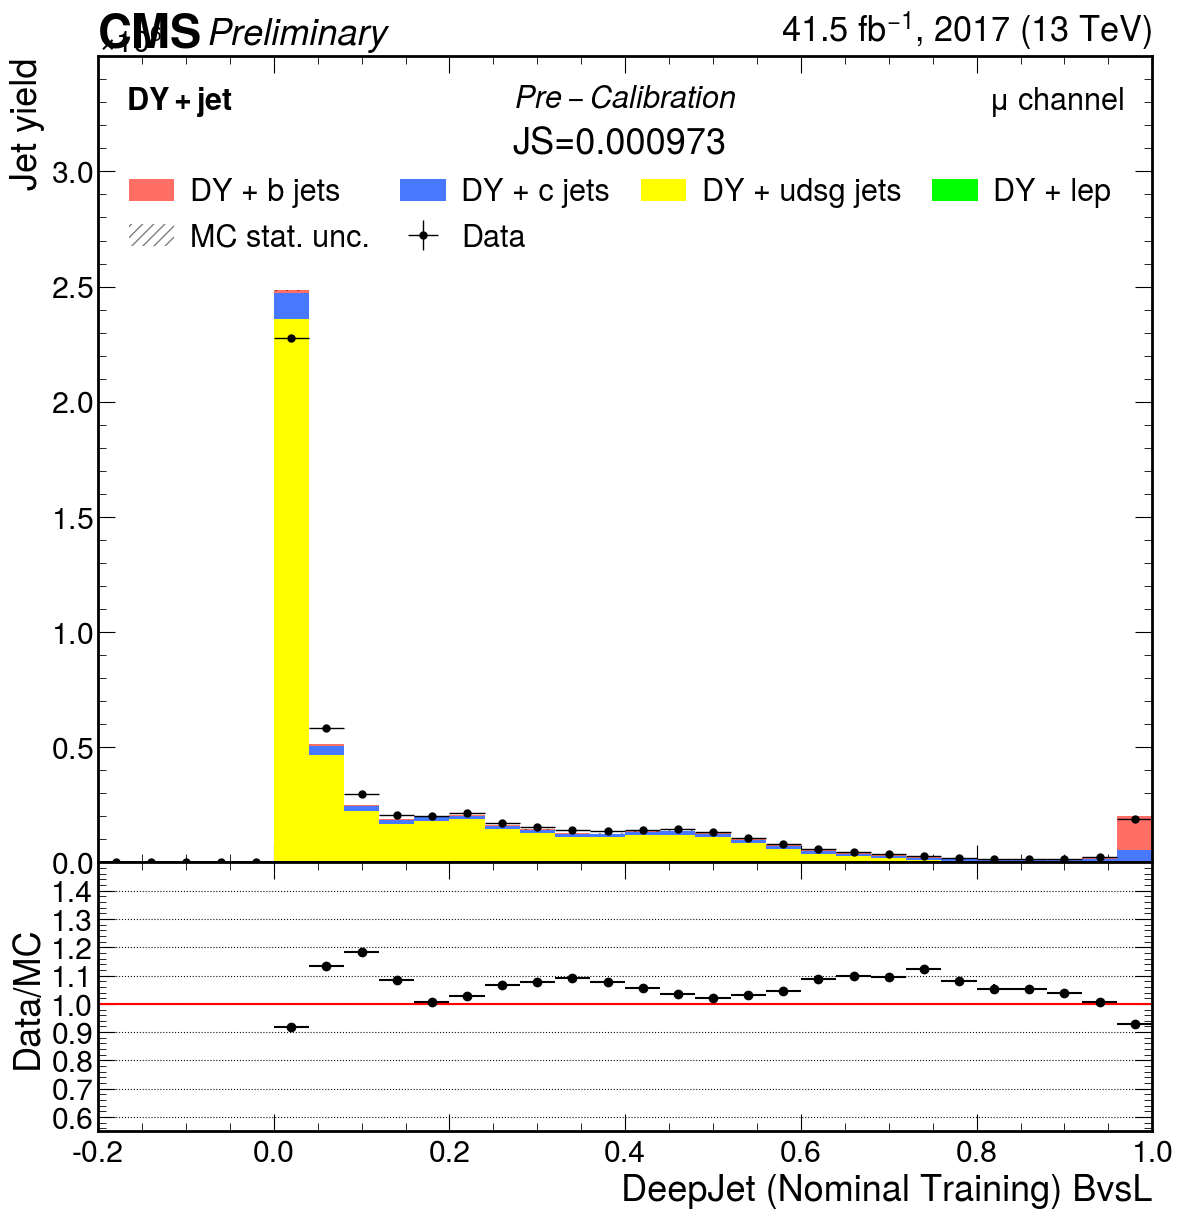

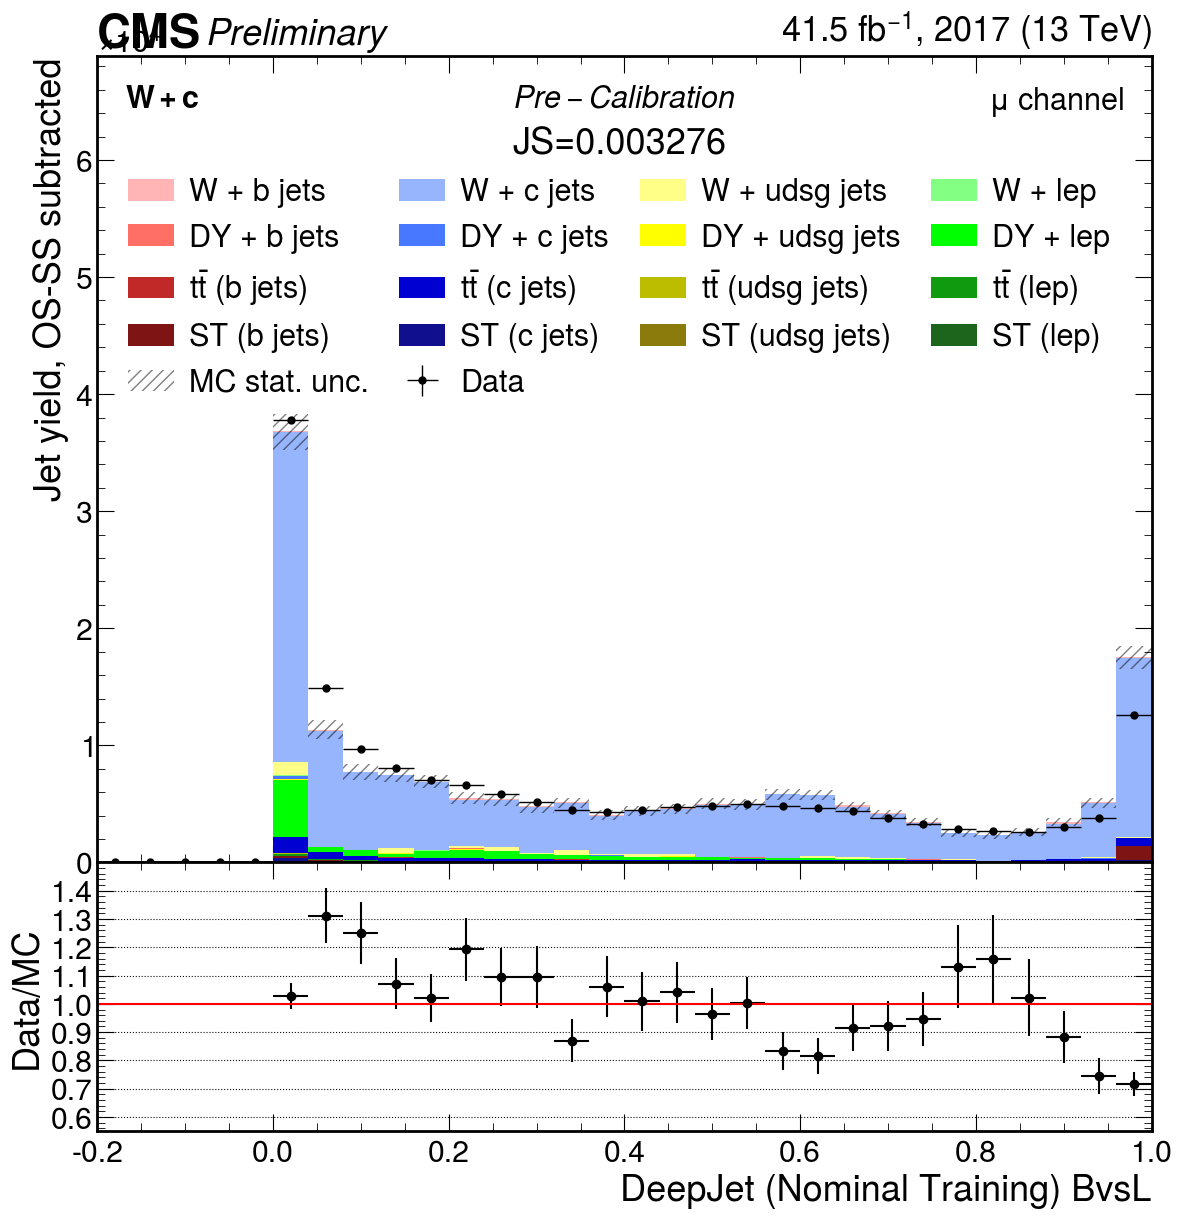

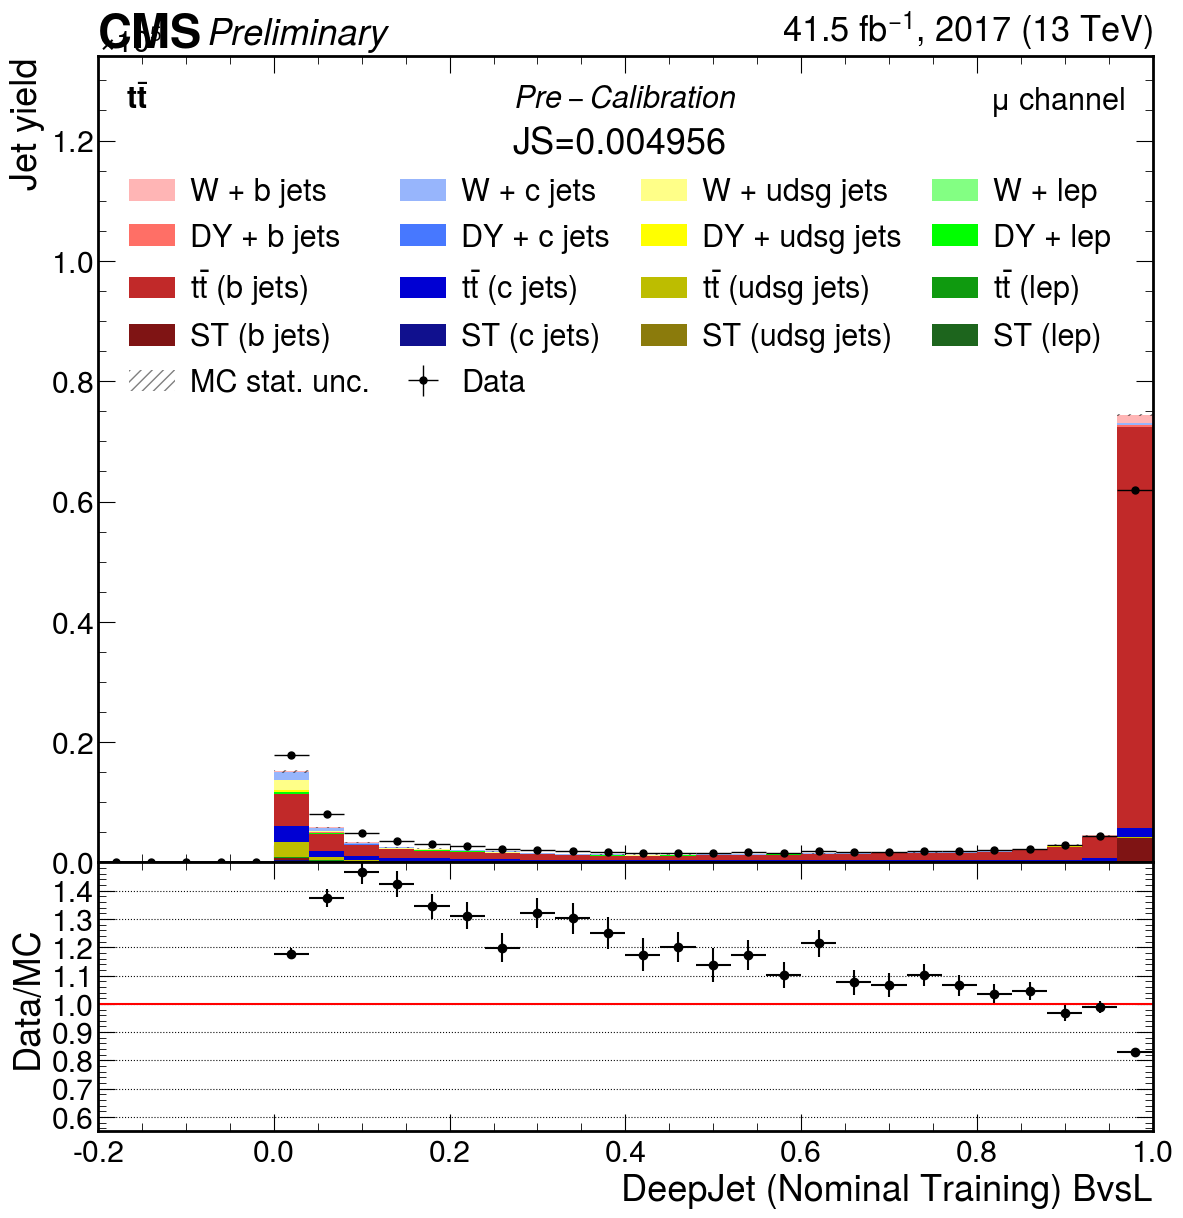

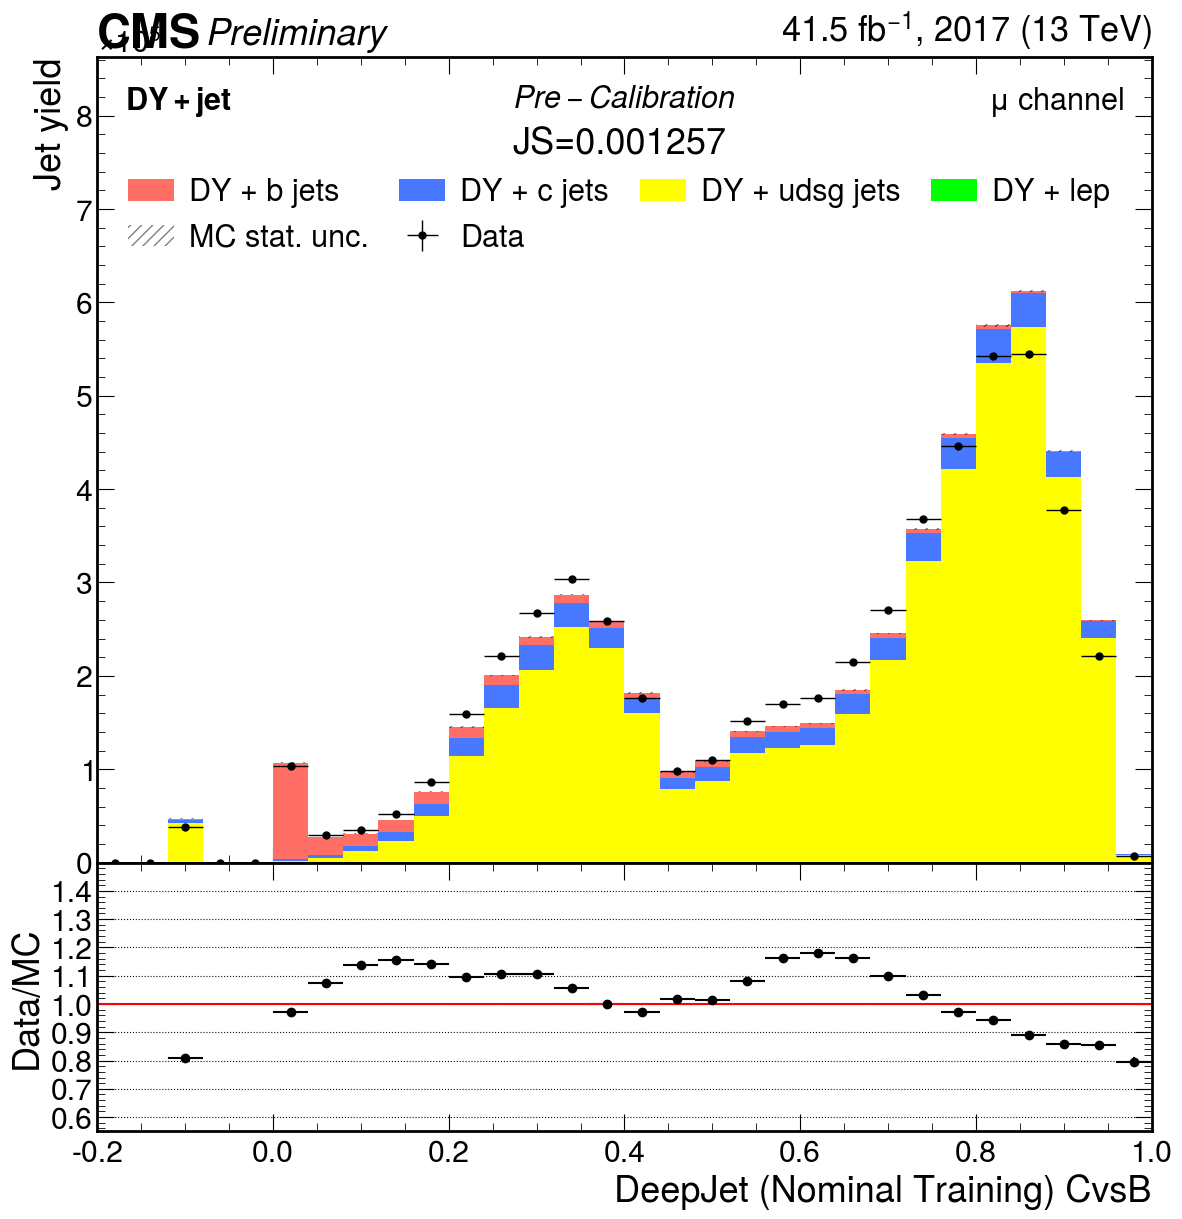

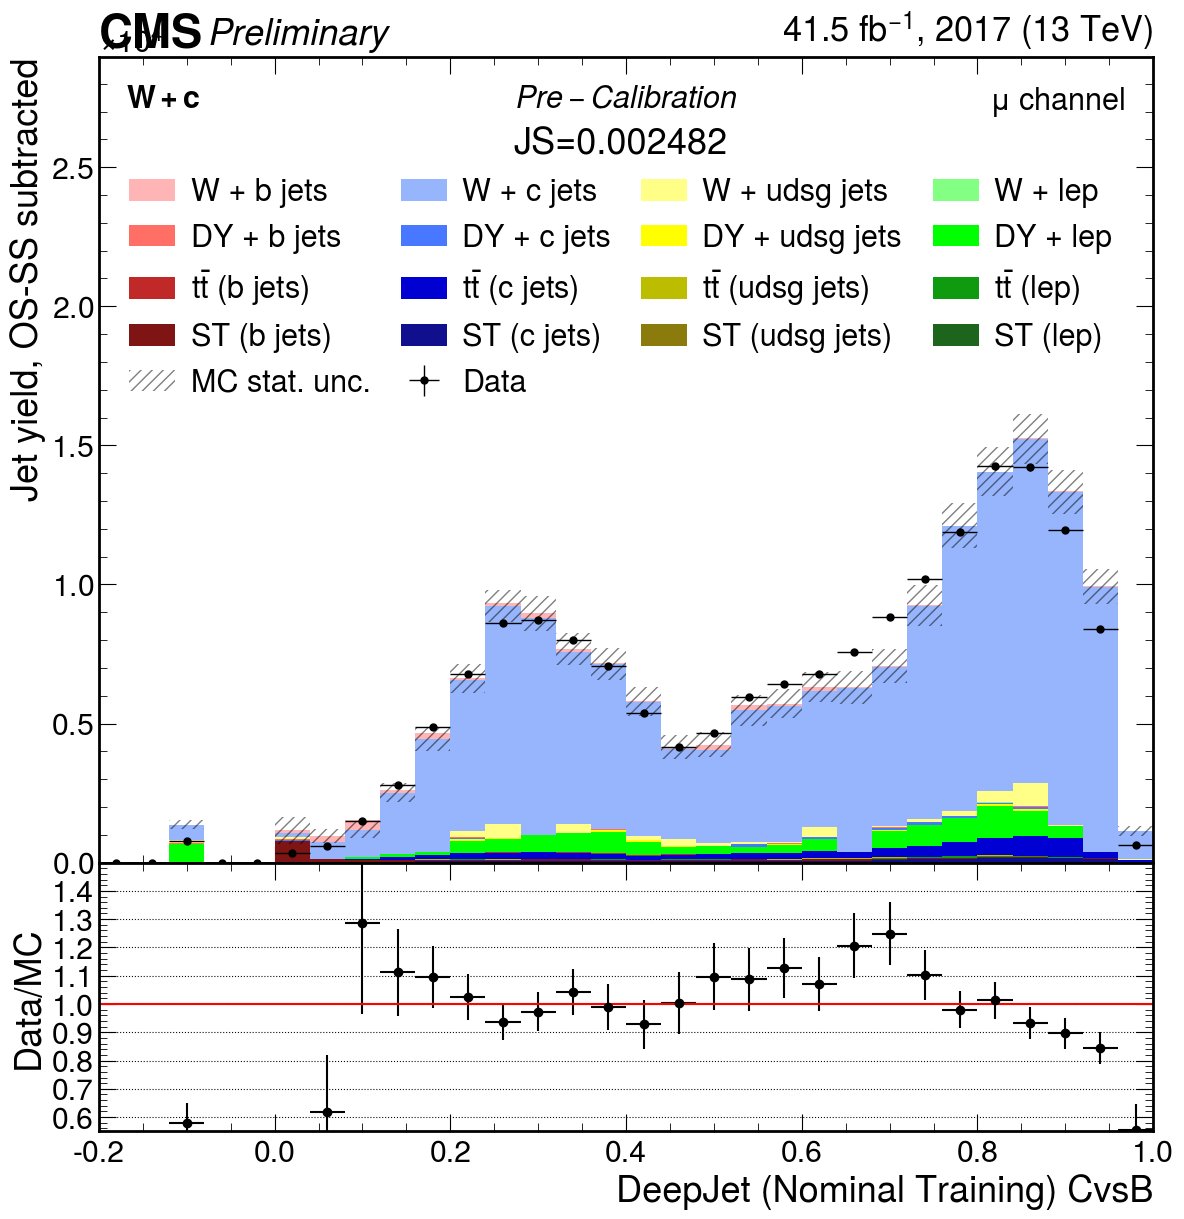

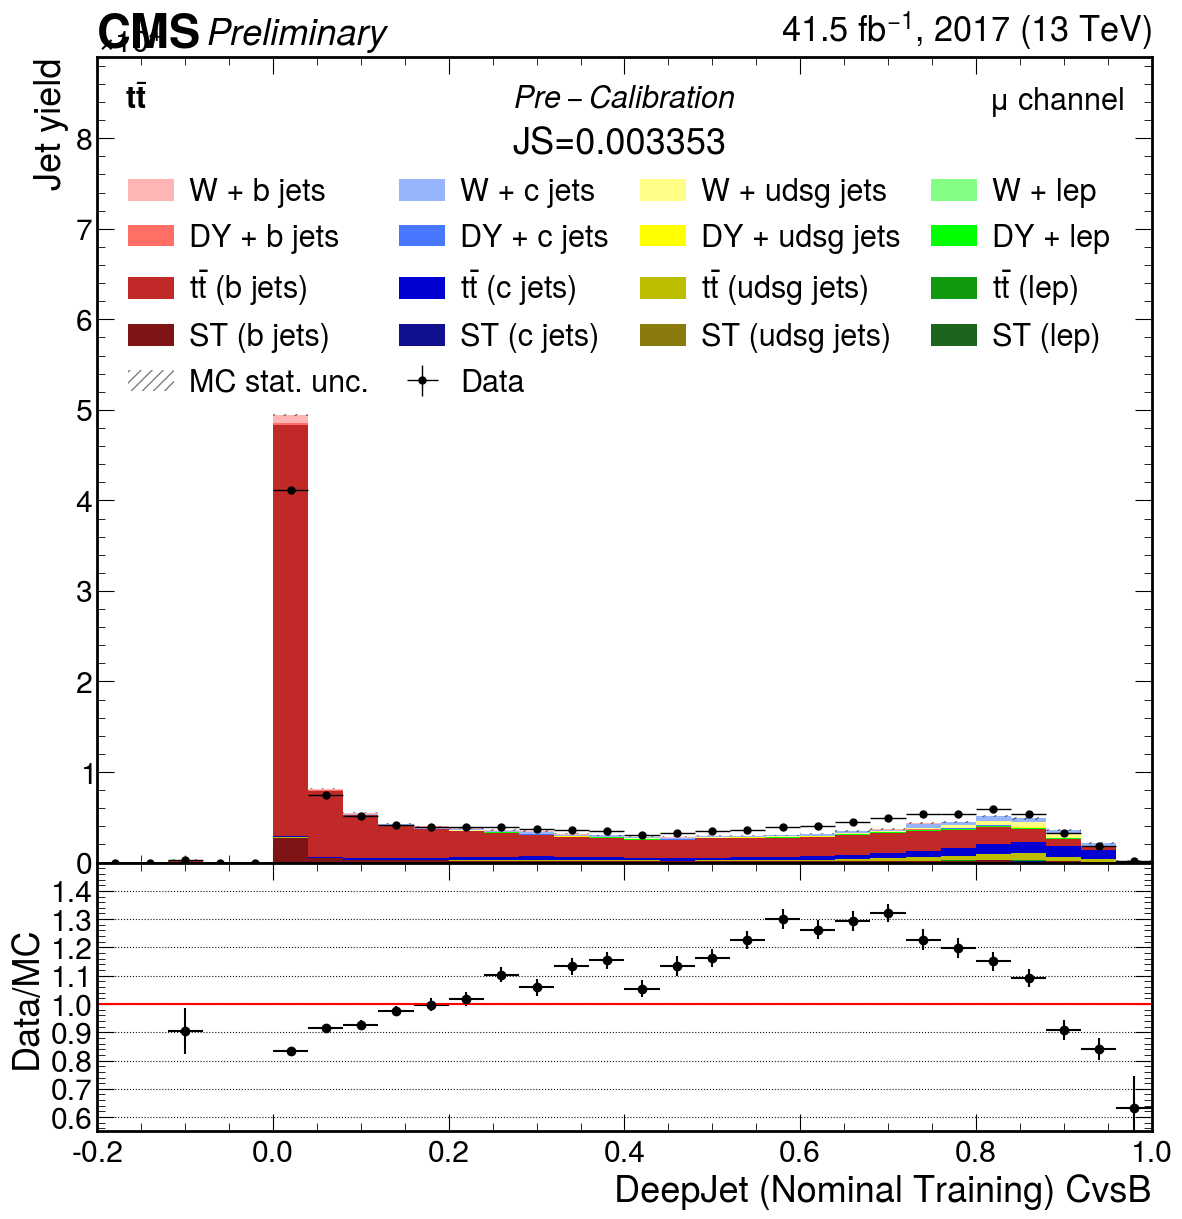

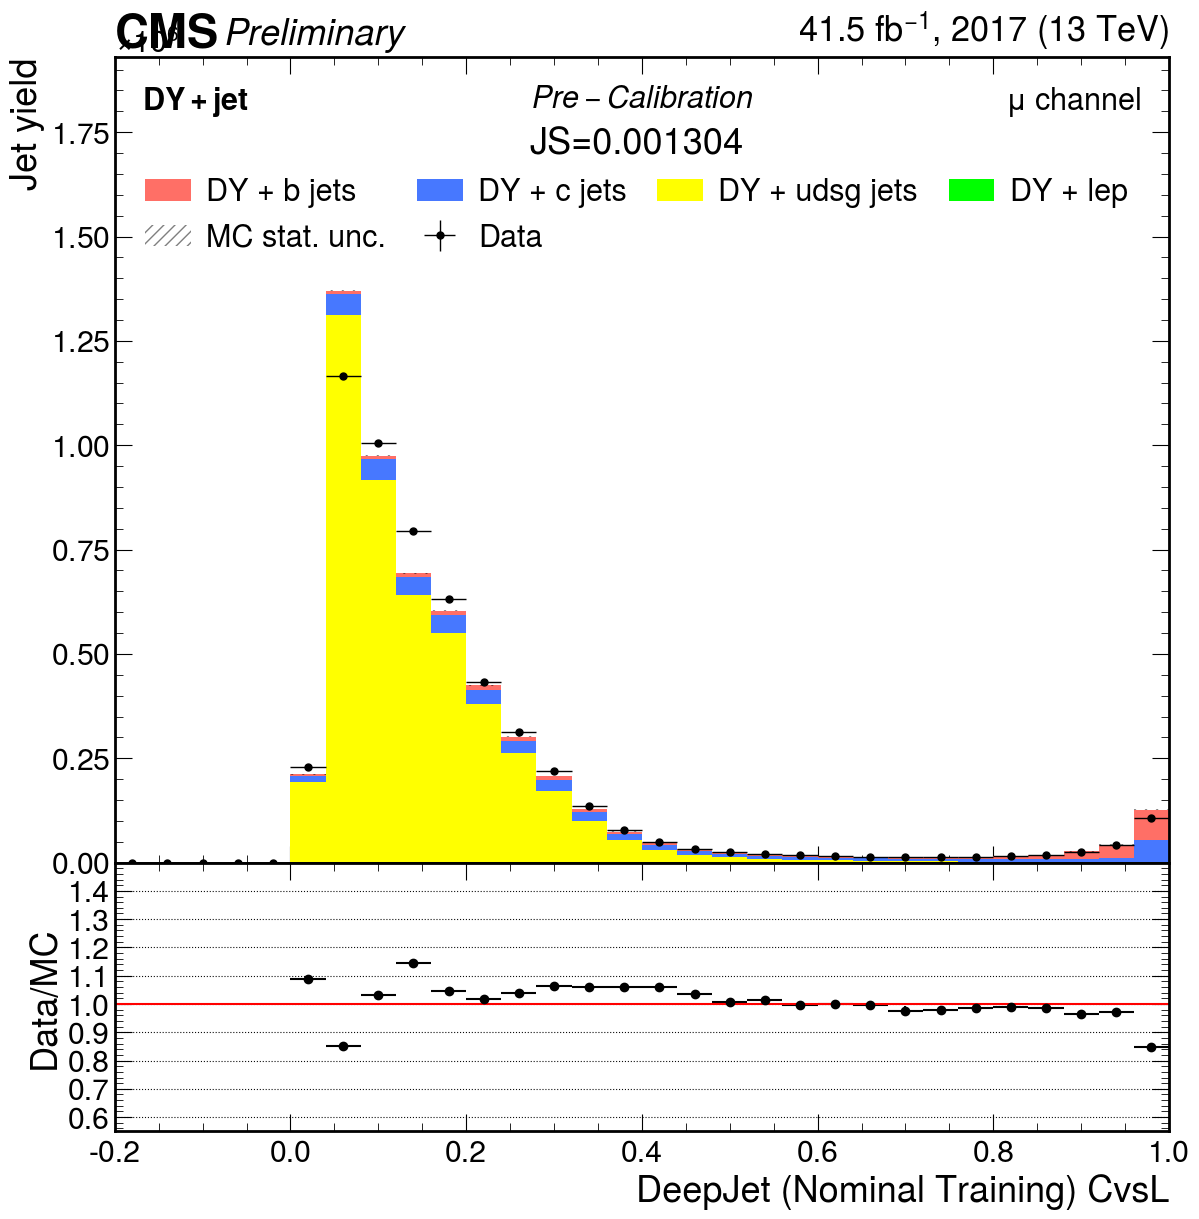

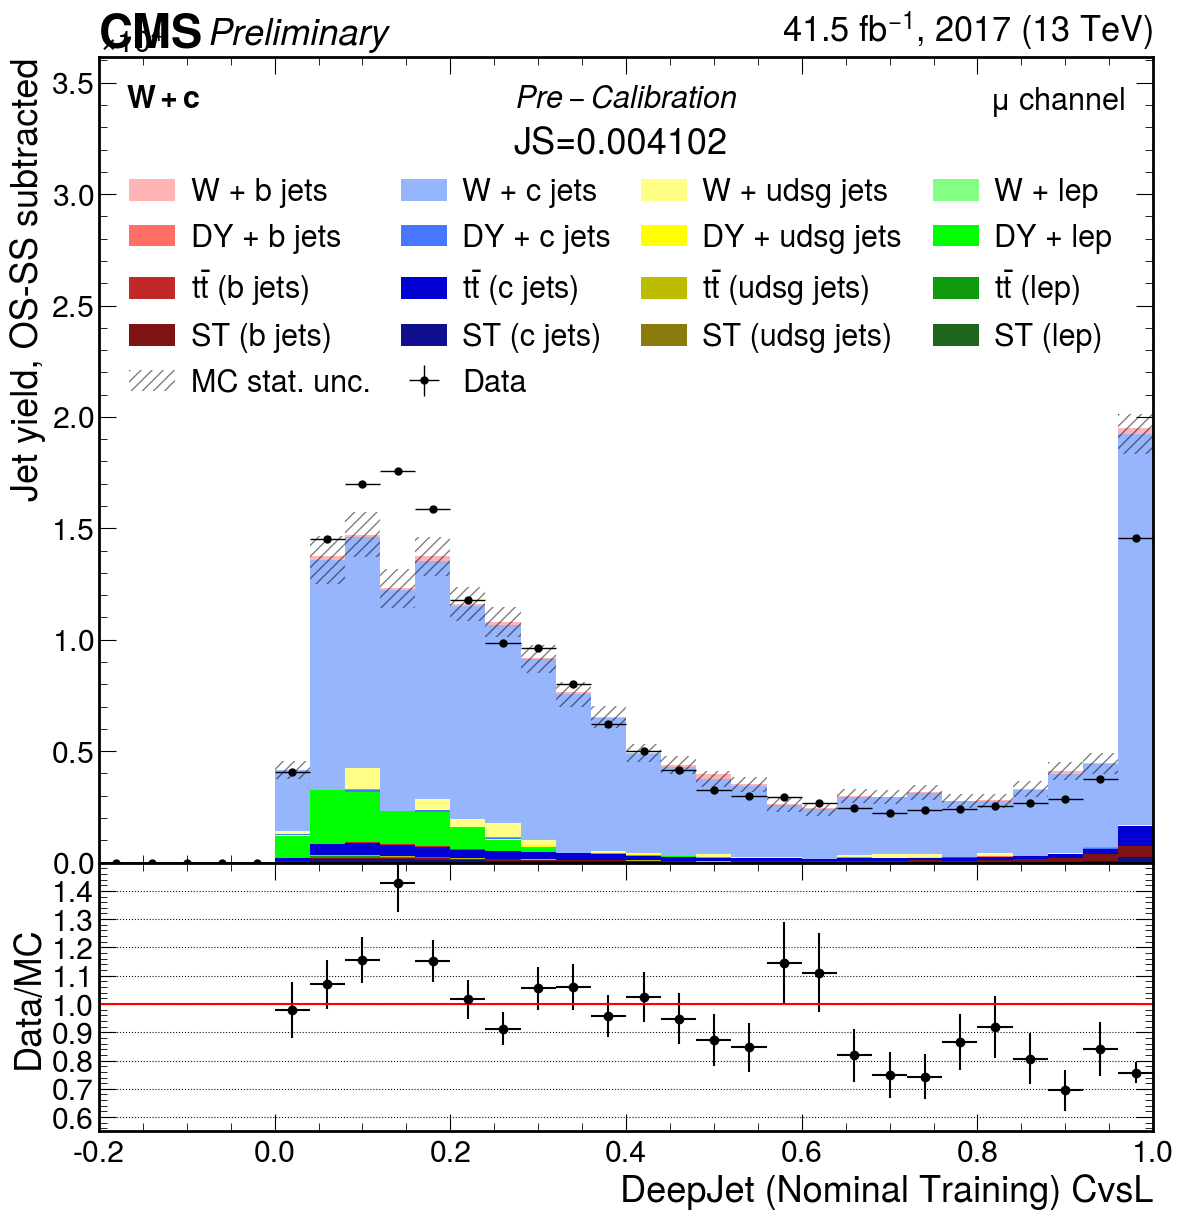

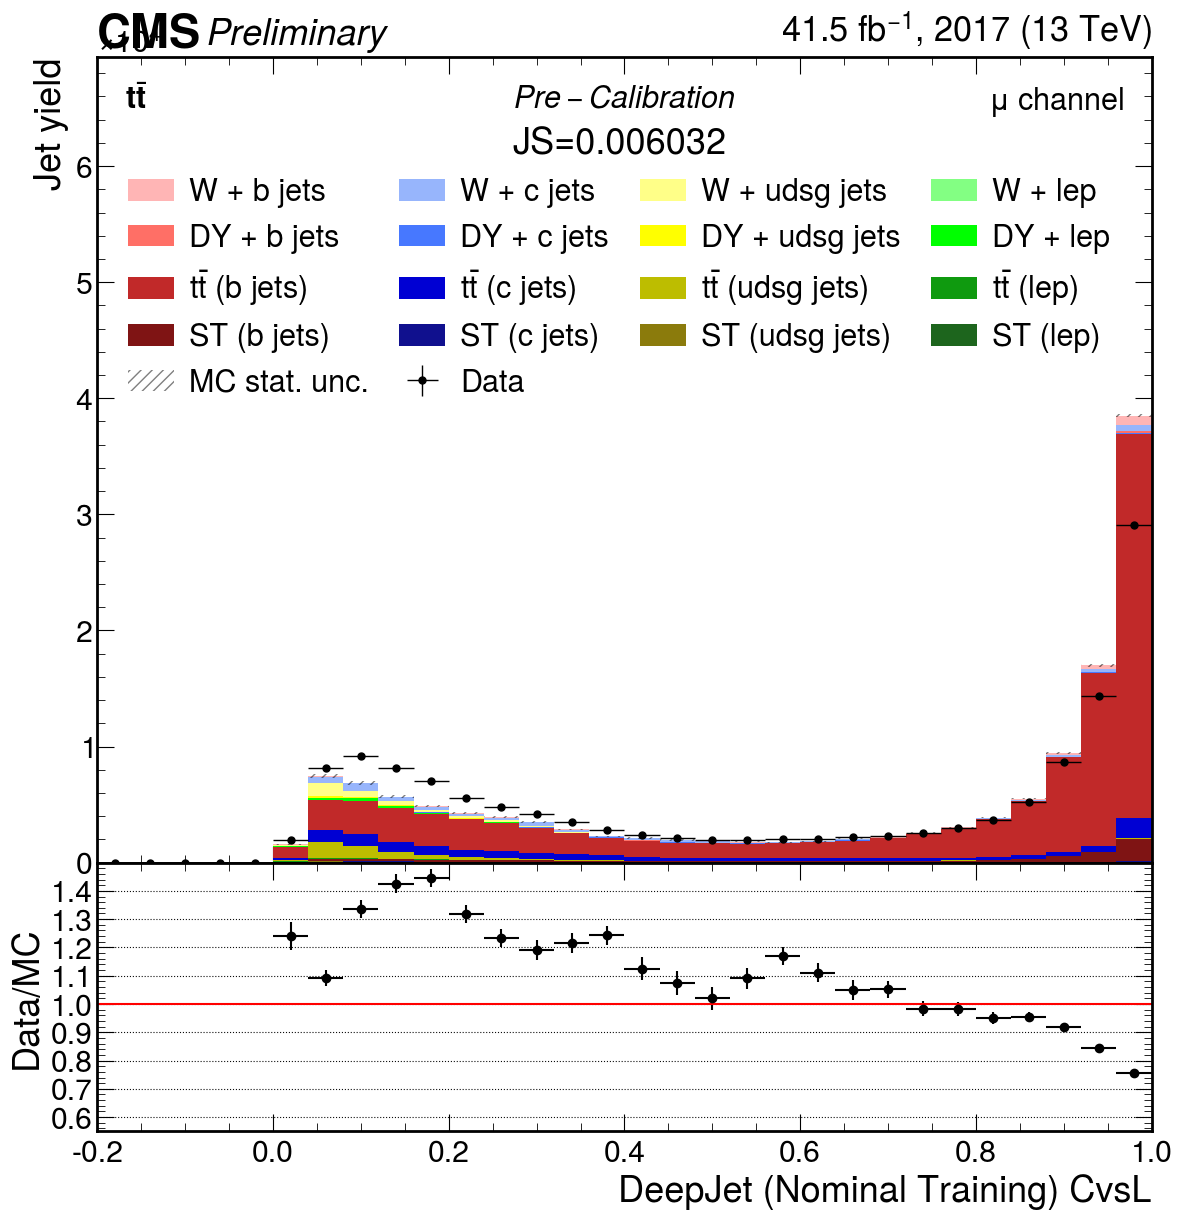

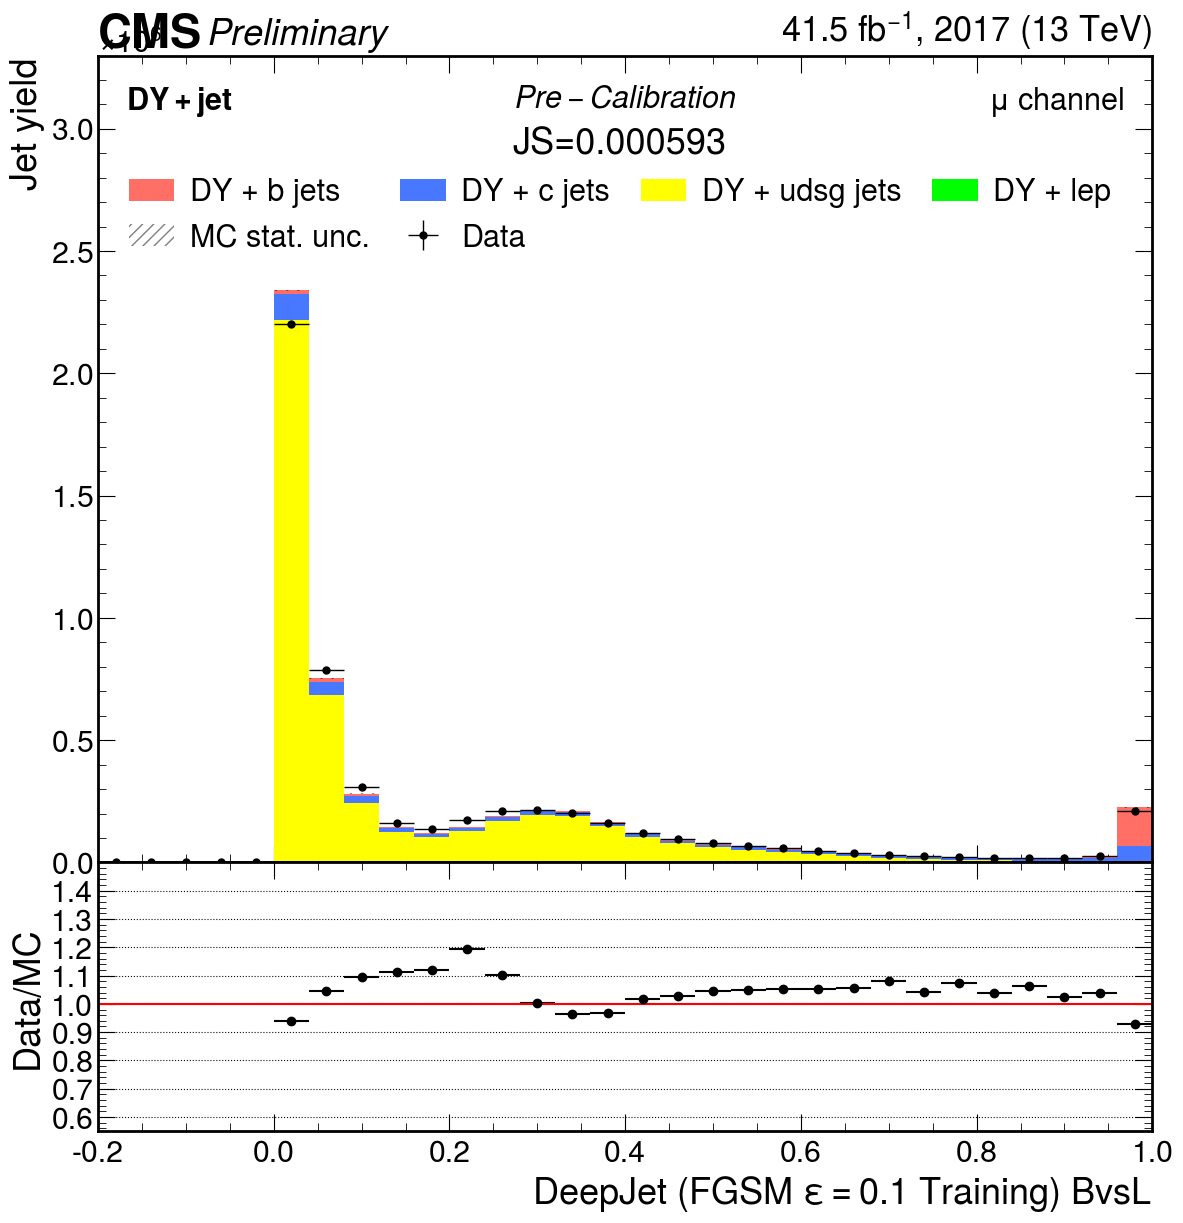

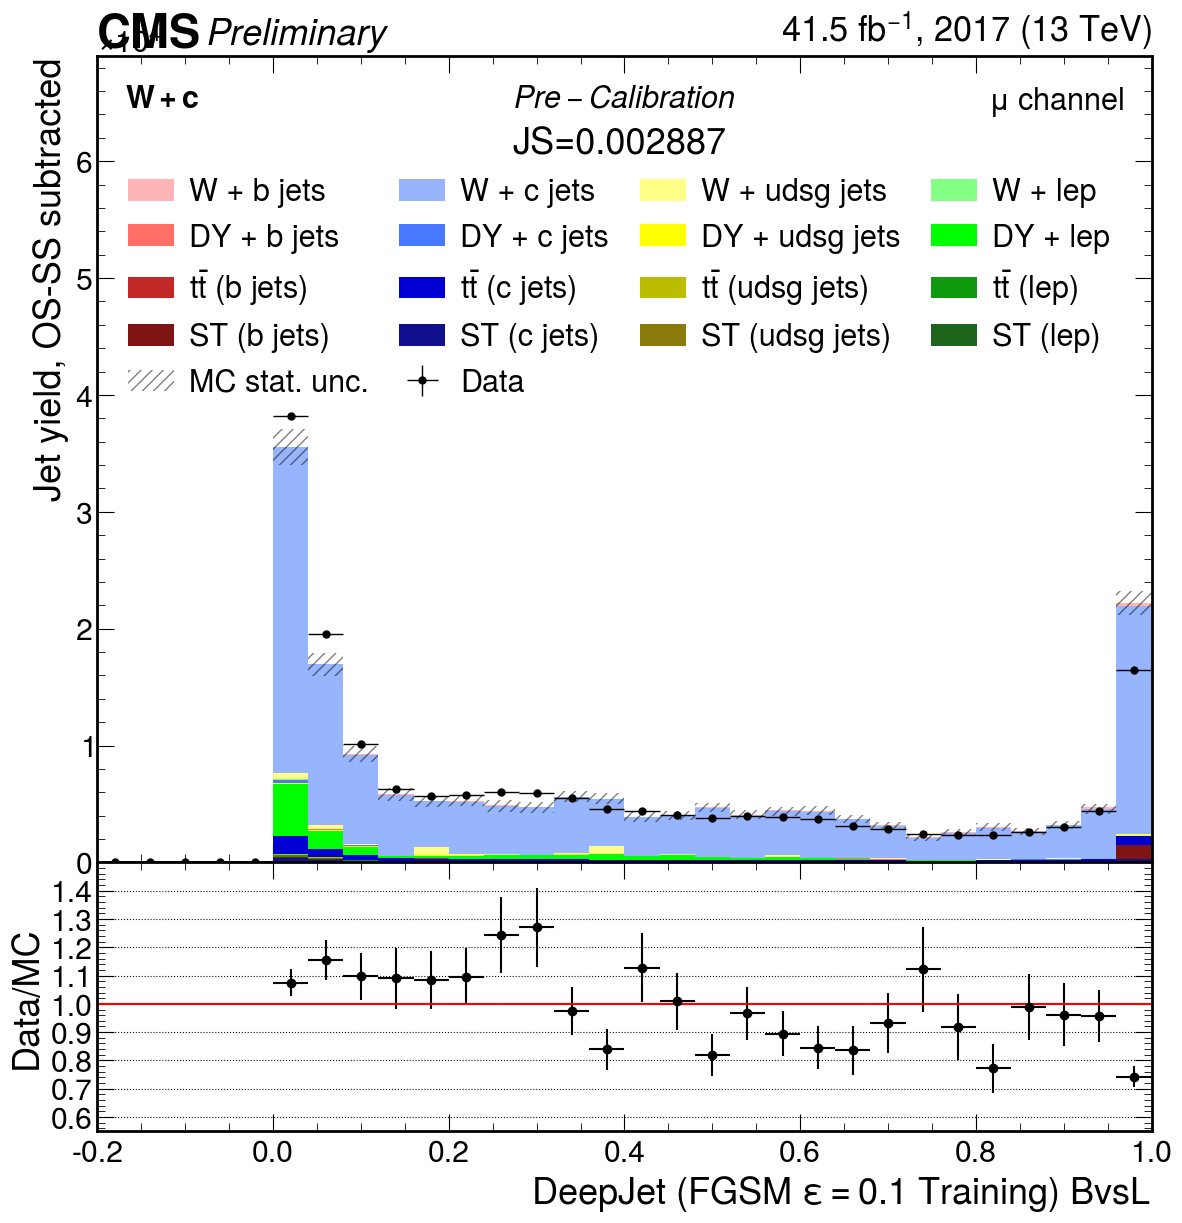

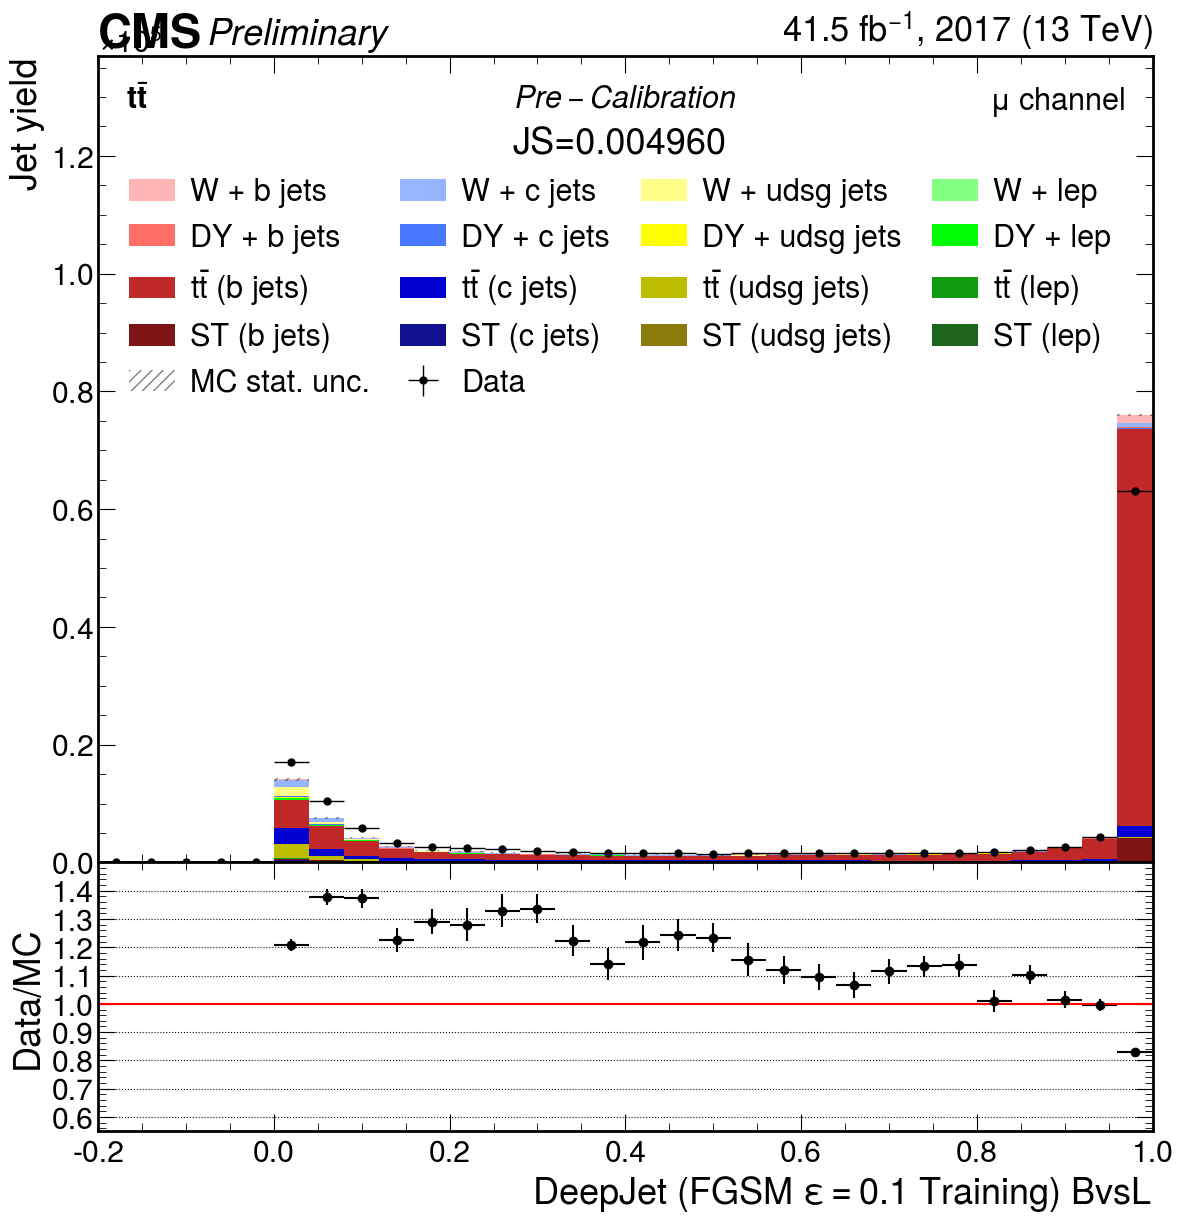

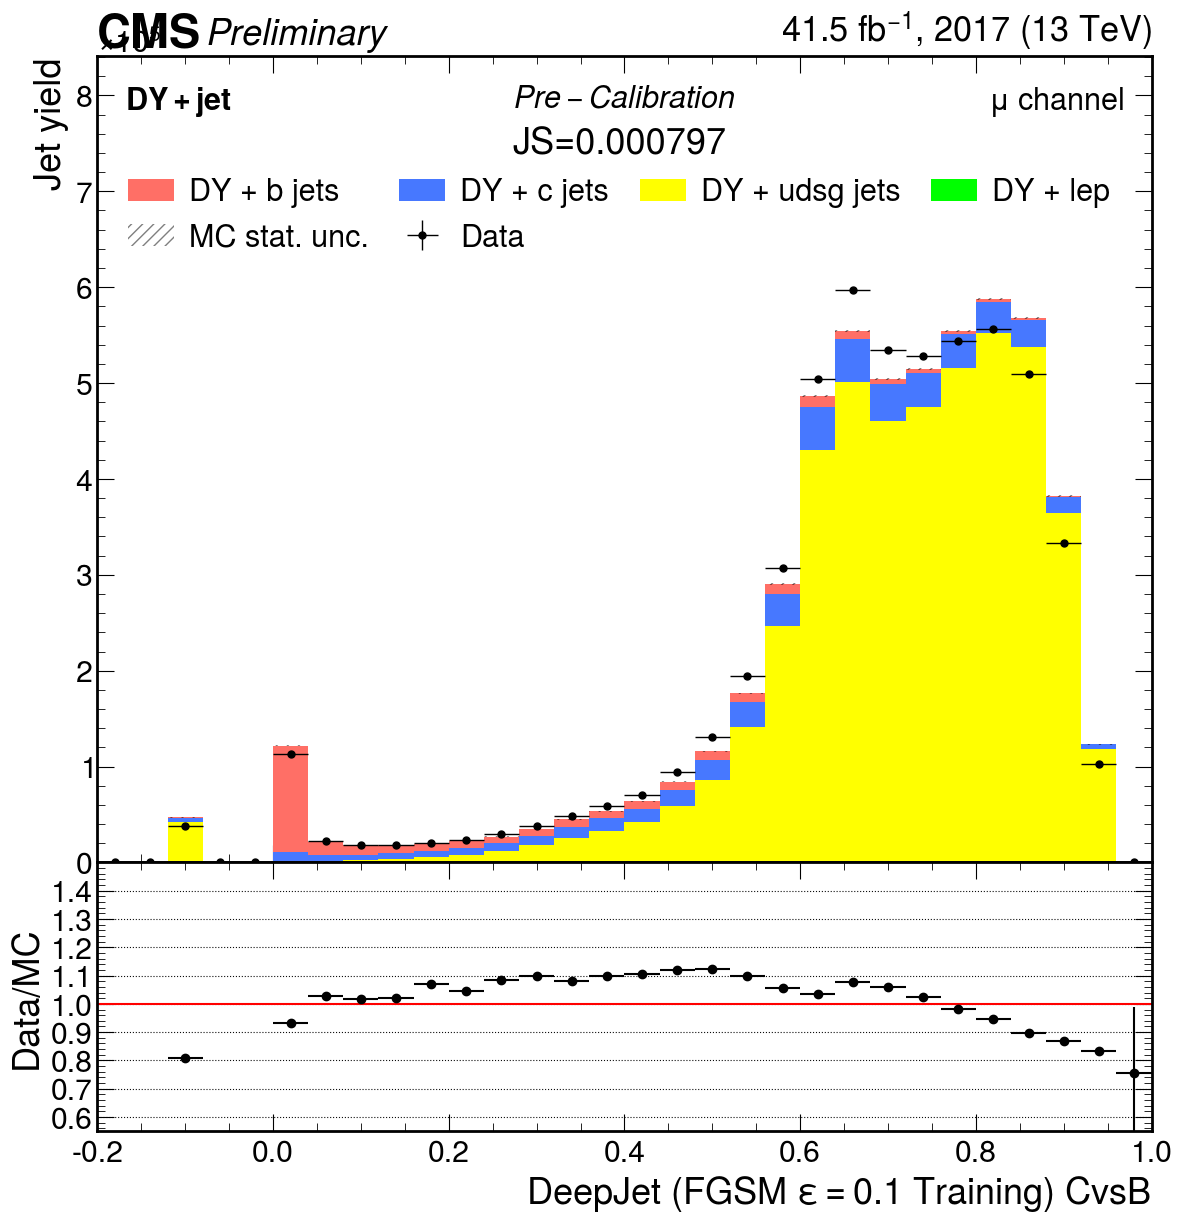

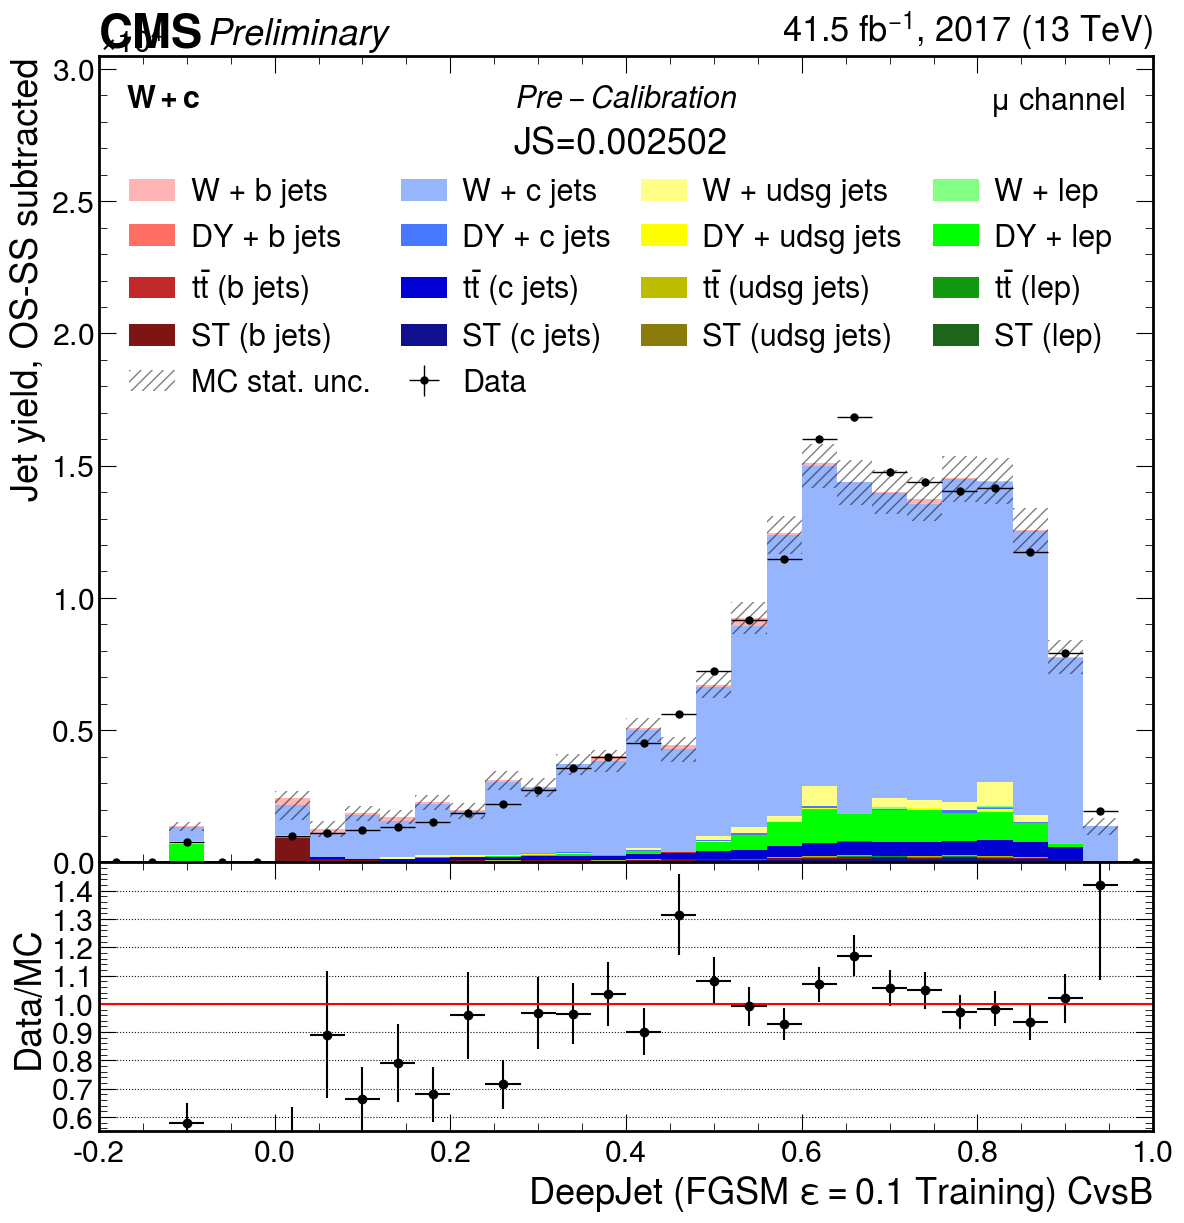

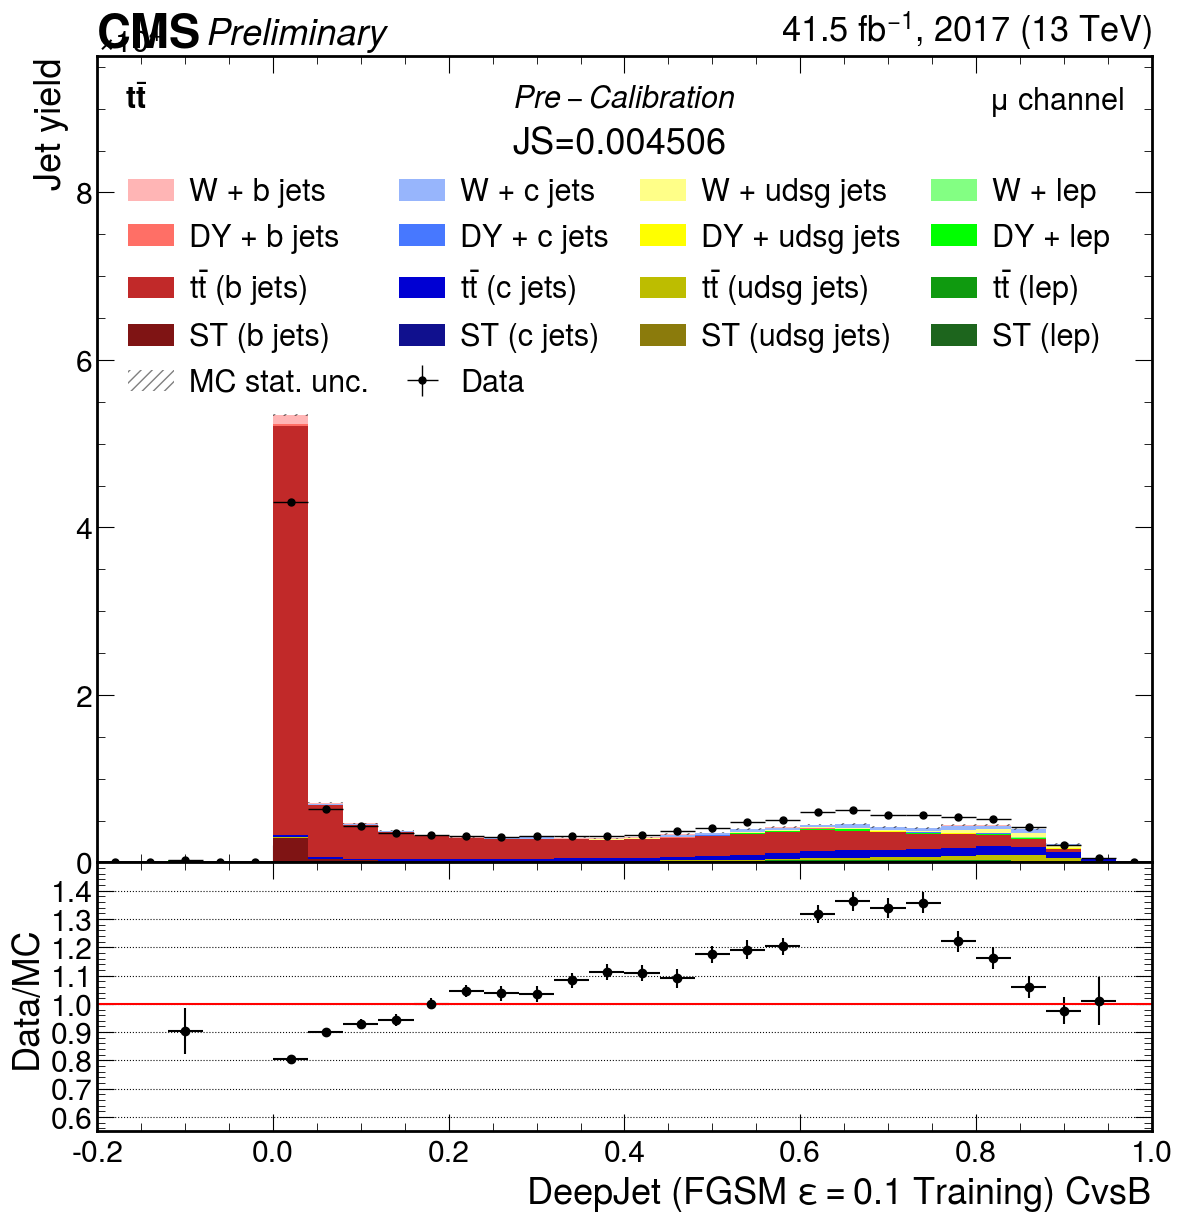

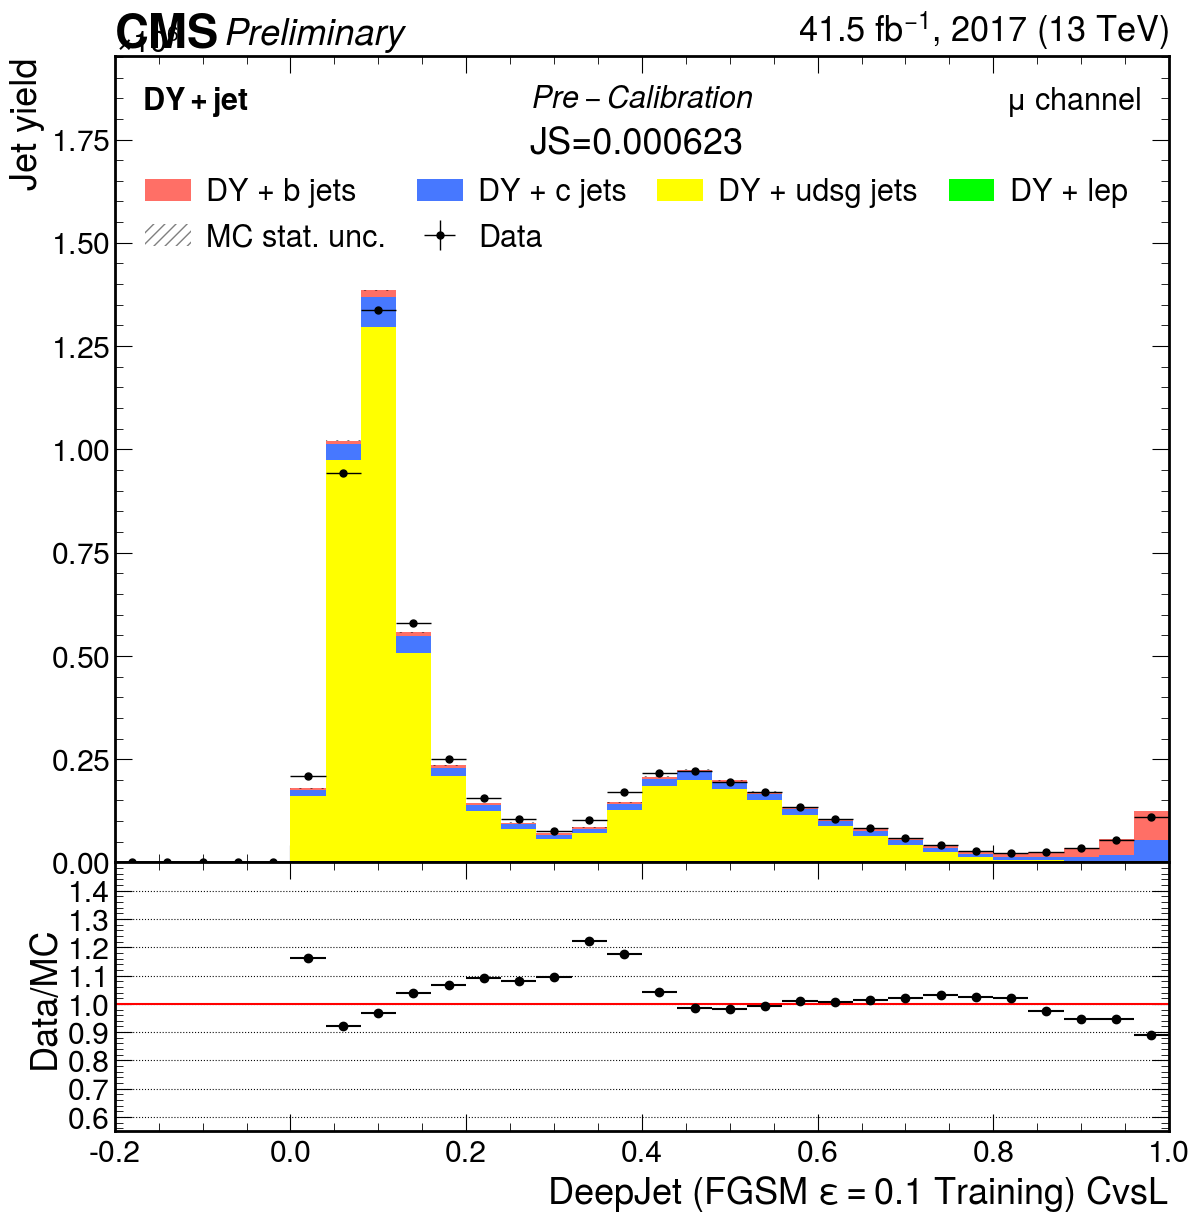

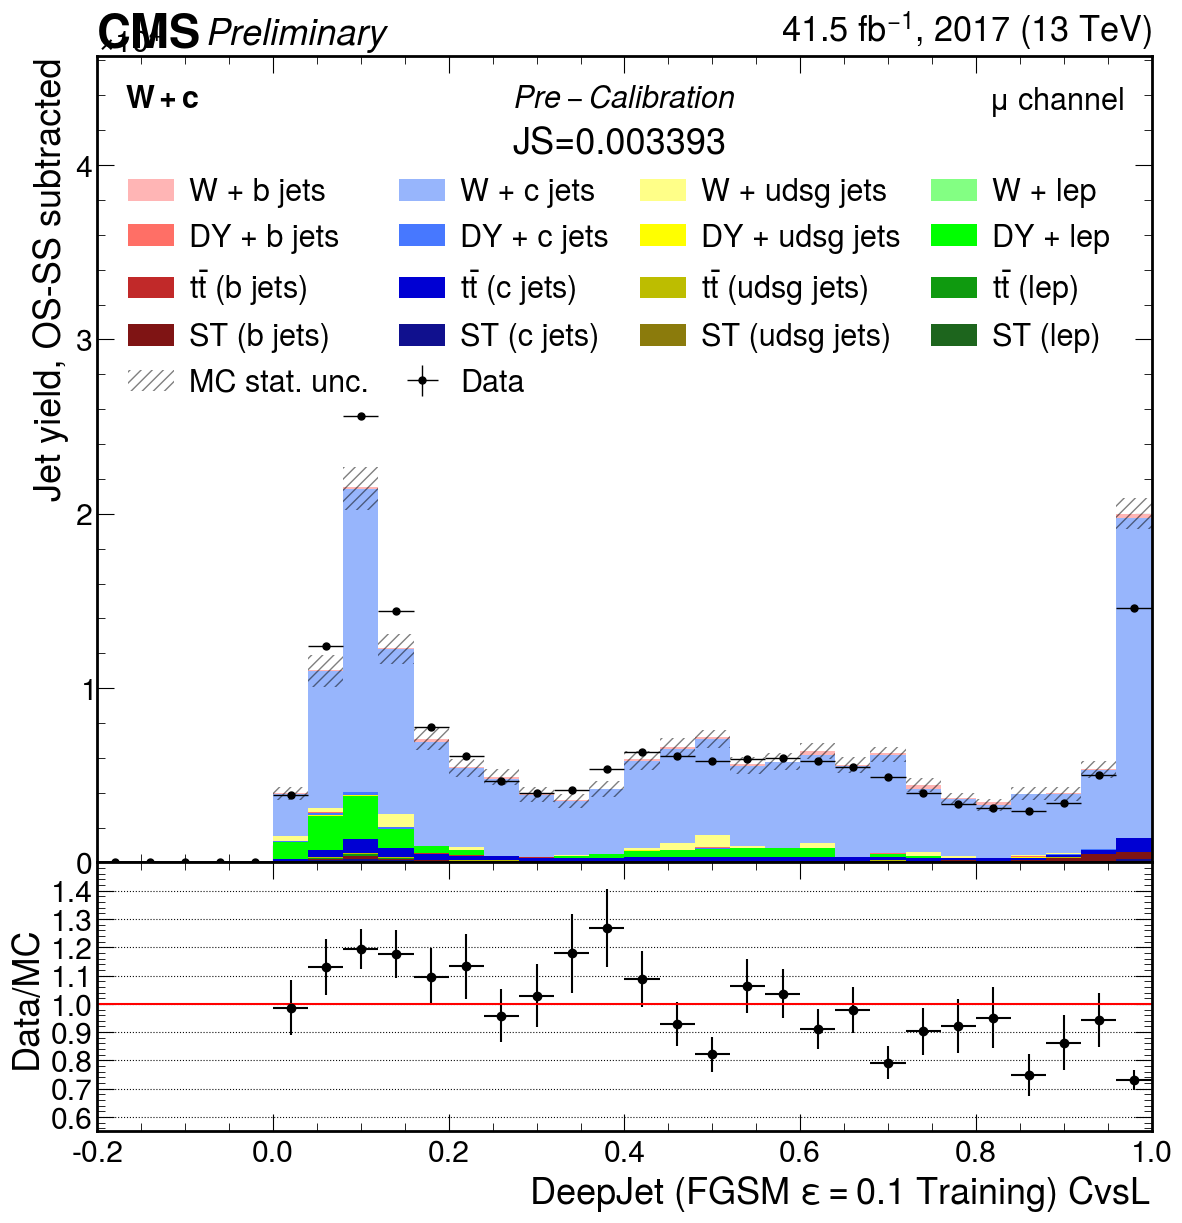

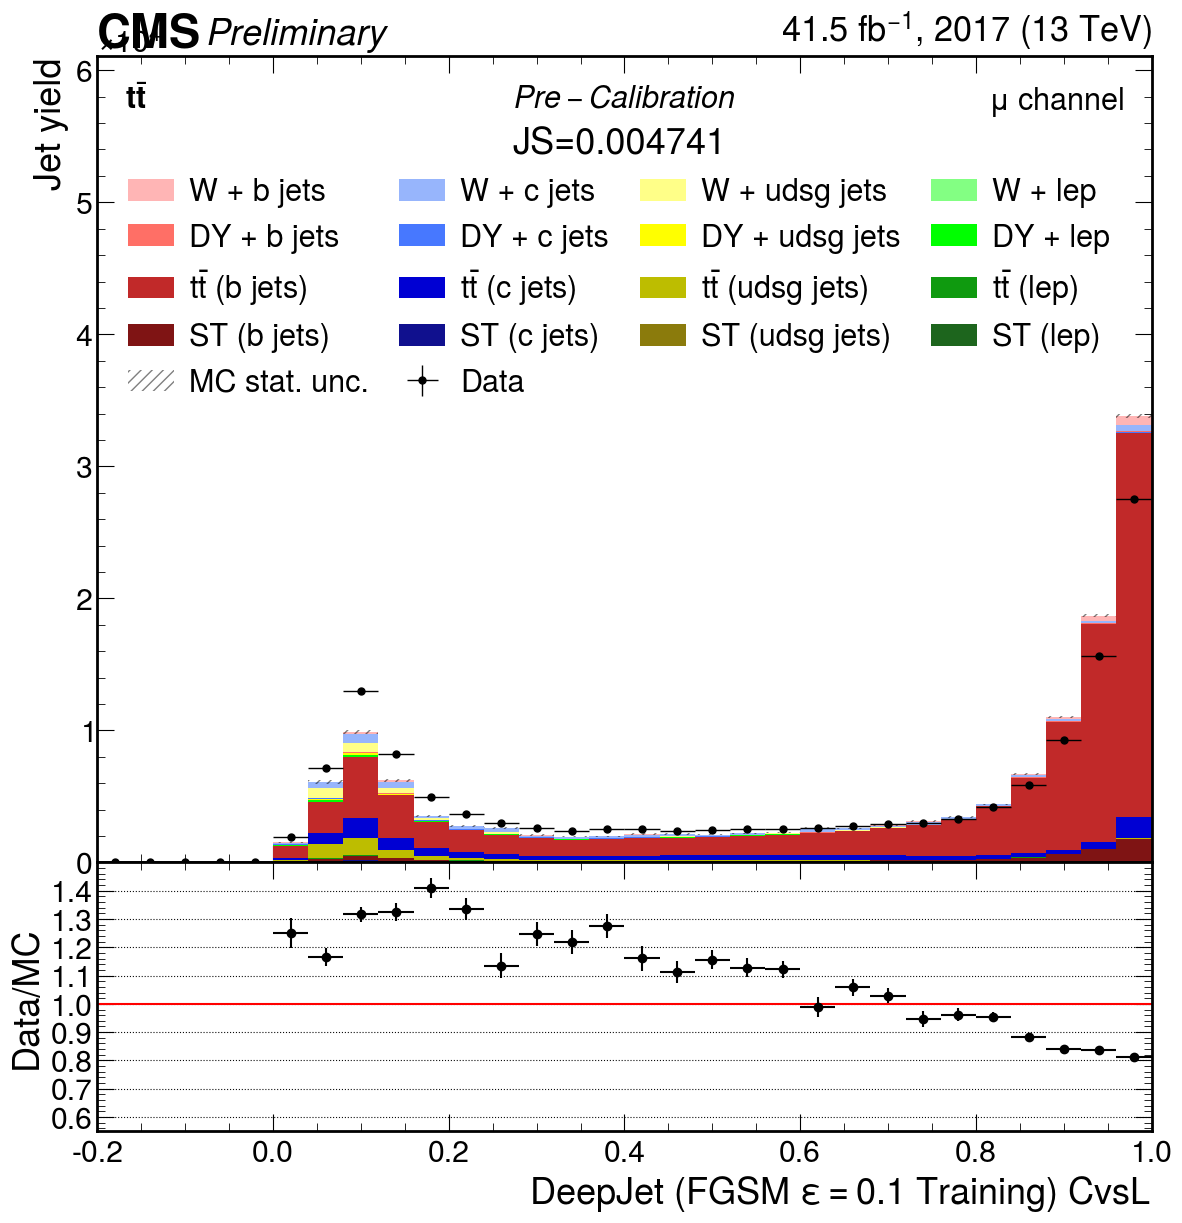

In [31]:
# create Data vs MC comparison plots
taggers = ['nominal','fgsm-0_1']#,'fgsm-0_15',]
discriminators = ['BvsL','CvsB','CvsL']
selections = ['DY_m','Wc_m','TT_semim']

for tagger in taggers:
    for discriminator in discriminators:
        for selection in selections:
            plotStack(tagger, selection, discriminator)

In [9]:
models = ['nominal','fgsm-0_1','fgsm-0_15']#]#]
selections = ['DY_m','Wc_m','TT_semim']
discriminators = ['BvsL','CvsB','CvsL']
include_DPnote = True # optional: include JS values from DPnote in LaTeX table?

# calculate JS divergence values for all models
js_table = np.zeros((len(models),len(selections)*len(discriminators)))
for i,model in enumerate(models):
    # nominal model is saved in the other directories
    if model=='nominal':
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{models[1]}/systPlots_2023/output_2017_PFNano_central' 
        #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' # old models
    else:
        path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/systPlots_2023/output_2017_PFNano_central'
        #path = '/nfs/dust/cms/user/hschonen/ctag_condor/systPlots_2023/output_2017_PFNano_central' #old models
    for j,selection in enumerate(selections):
        for k,discriminator in enumerate(discriminators):
            if model=='nominal':
                histo = uproot.open(f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
                #print('open: ',f'{path}/{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
            else:
                histo = uproot.open(f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
                #print('open: ',f'{path}/{selection}_jet_CustomADV{discriminator}_{jet_index[selection]}_.root')
            # get Data and MC sum
            data = histo['Data'].values()
            MCsum = histo['MCSum'].values()
            #print(data)
            #print(MCsum)
            MCsum[(MCsum==0)&(data!=0)] = 0.00001
            negative_values = (data<0) | (MCsum<0)
            data[negative_values] = 0
            MCsum[negative_values] = 0 
            js_value = jsdiv(data, MCsum, normalize_first=True)
            js_table[i,j*len(discriminators)+k] = js_value
print(js_table)

[[0.00097332 0.00125668 0.00130409 0.00327636 0.00248225 0.00410233
  0.00495643 0.0033532  0.00603225]
 [0.00059299 0.00079696 0.00062263 0.00288692 0.00250177 0.00339289
  0.00496007 0.00450636 0.00474136]
 [0.00024167 0.00079017 0.00027947 0.00250824 0.00217402 0.00244578
  0.0045746  0.00448763 0.0041713 ]]


/tmp/ipykernel_4150/2366347894.py:3: RuntimeWarning: invalid value encountered in divide
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_4150/2366347894.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])
/tmp/ipykernel_4150/2366347894.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum([v for v in A * np.log(A/B) if not np.isnan(v)])


In [10]:
# automatic LateX formatting
def JS_Latex(js_table, models, selections, discriminators):
    print('\\begin{table}[h]')
    print('\\label{tab:js_values}')
    print('\\caption{JS divergence values}')
    print('\\resizebox{\\textwidth}{!}{')
    tabular_line = '\\begin{tabular}{|c|'
    header_line = 'model '
    new_line = '\\\\ \\hline '
    for selection in selections:
          for discriminator in discriminators:
                tabular_line = tabular_line + 'c|'
                header_line = header_line + f'& {discriminator} '
                new_line = new_line + '&'
    new_line = new_line + ' \\\\ [-1em]'
    tabular_line = tabular_line + '}'
    header_line = header_line + new_line
    print(tabular_line)
    print('\hline')
    print(header_line)
    for i,model in enumerate(models):
        line = model_labels[model]
        for j in range(len(selections)*len(discriminators)):
            if js_table[i,j]==np.min(js_table[:,j]):
                line = line + ' & $\\textbf{'+'{:.6f}'.format(js_table[i,j])+'}$'
            else:
                line = line + ' & {:.6f}'.format(js_table[i,j])
        line = line + ' ' + new_line
        print(line)
    if include_DPnote:
        print('nominal (DPnote) & 0.000358 & 0.000353 & 0.000947 & 0.002632 & $\\textbf{0.002350}$ & 0.002263 & 0.003506 & $\\textbf{0.002528}$ & 0.004820 \\\\ \\hline &&&&&&&&& \\\\[-1em]')
        print('adversarial (DPnote) & $\\textbf{0.000063}$ & $\\textbf{0.000058}$ & $\\textbf{0.000466}$ & $\\textbf{0.001887}$ & 0.003074 & $\\textbf{0.001766}$ & $\\textbf{0.003329}$ & 0.003005 & $\\textbf{0.002924}$ \\\\ \\hline')
    print('\\end{tabular}}')
    print('\\end{table}')

\begin{table}[h]
\label{tab:js_values}
\caption{JS divergence values}
\resizebox{\textwidth}{!}{
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
model & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL & BvsL & CvsB & CvsL \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (Nominal Training) & 0.000973 & 0.001257 & 0.001304 & 0.003276 & 0.002482 & 0.004102 & 0.004956 & $\textbf{0.003353}$ & 0.006032 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.1$ Training) & 0.000593 & 0.000797 & 0.000623 & 0.002887 & 0.002502 & 0.003393 & 0.004960 & 0.004506 & 0.004741 \\ \hline &&&&&&&&& \\ [-1em]
DeepJet (FGSM $\epsilon=0.15$ Training) & $\textbf{0.000242}$ & $\textbf{0.000790}$ & $\textbf{0.000279}$ & $\textbf{0.002508}$ & $\textbf{0.002174}$ & $\textbf{0.002446}$ & $\textbf{0.004575}$ & 0.004488 & $\textbf{0.004171}$ \\ \hline &&&&&&&&& \\ [-1em]
nominal (DPnote) & 0.000358 & 0.000353 & 0.000947 & 0.002632 & $\textbf{0.002350}$ & 0.002263 & 0.003506 & $\textbf{0.002528}$ & 0.004820 \\ \hline &&&&&&&&& \\[-1em]

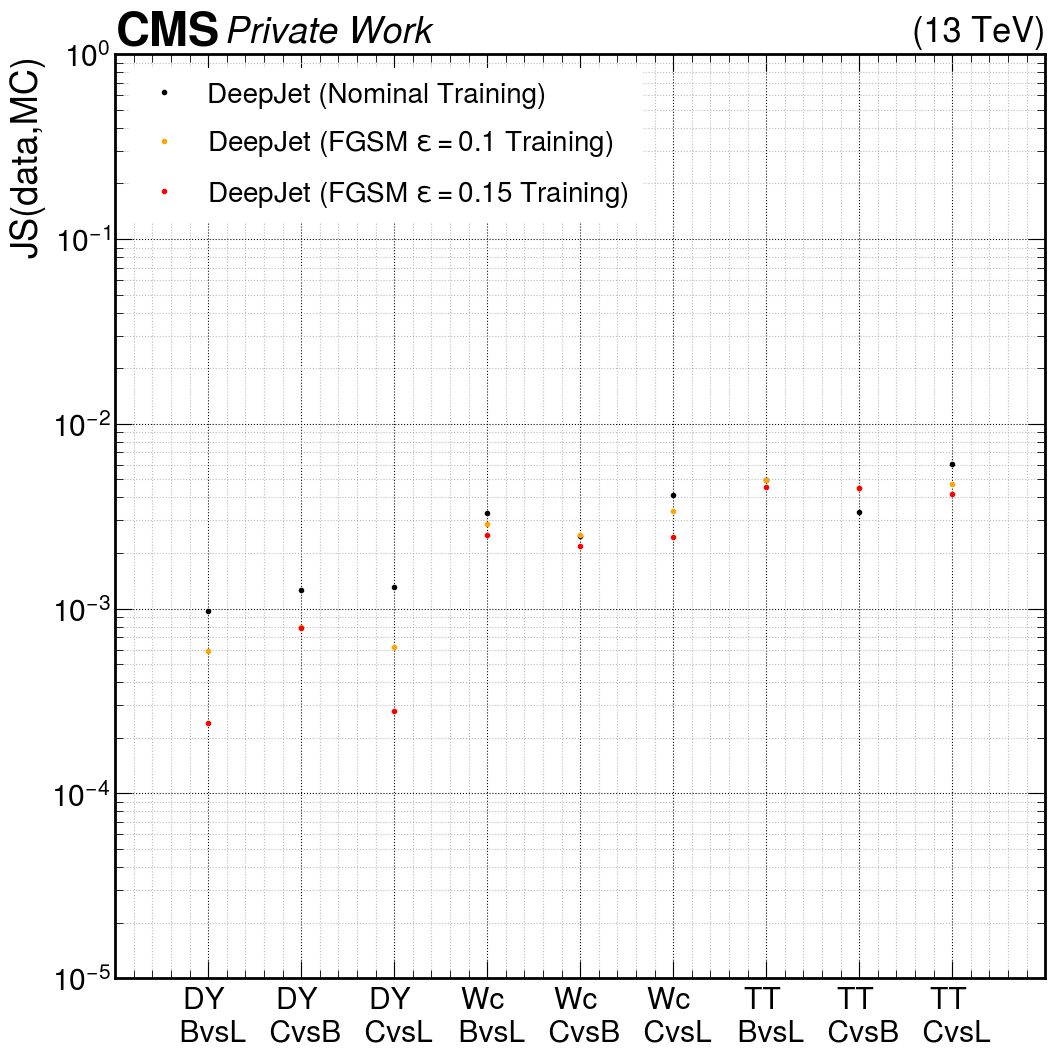

In [12]:
# Plotting the JS divergence values:
model_colors = {
    'nominal': 'black',
    'fgsm-0_1': 'orange',
    'fgsm-0_15': 'red',
}
def PlotJS(js_table, models, selection, discriminators):
    fig,ax = plt.subplots(figsize=[12,12])
    plt.style.use(hep.cms.style.ROOT)
    ax.set_xlim(left=0.,right=10)
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.00001,top=1)
    ax.set_ylabel('JS(data,MC)')
    #ax.set_xlabel('Discriminator')
    ax.grid(which='minor', alpha=0.85)
    ax.grid(which='major', alpha=0.95, color='black')
    # choose arbitrary positions to place the JS values
    x = [1,2,3,4,5,6,7,8,9]
    # set x ticks
    labels = ['DY \n BvsL','DY \n CvsB','DY \n CvsL','Wc \n BvsL','Wc \n CvsB','Wc \n CvsL','TT \n BvsL','TT \n CvsB','TT \n CvsL']
    ax.set_xticks(x,labels)
    for i,model in enumerate(models):

        ax.plot(x, js_table[i,:], label=model_labels[model], color=model_colors[model], marker='.', linestyle='None')
    # make legend
    leg = ax.legend(title='',loc='upper left',ncols=1,fontsize=20,title_fontsize=20,labelspacing=0.7,frameon=True,framealpha=1,facecolor='white')
    leg._legend_box.align = 'left'
    leg.get_frame().set_linewidth(0.0)
    hep.cms.label(llabel='Private Work',rlabel='(13 TeV)')
    fig.savefig(save_dir + 'JS_values.pdf', bbox_inches='tight')
    fig.savefig('JS_values.pdf', bbox_inches='tight')

In [4]:
discriminators = ['BvsL','CvsB','CvsL']
selections = ['DY_m','Wc_m','TT_semim']
jet_index = {
    'DY_m': '0',
    'Wc_m': 'muJet_idx',
    'TT_semim': 'muJet_idx',
}


for selection in selections:
    for discriminator in discriminators:
        histo = uproot.open(path+f'{selection}_jet_Custom{discriminator}_{jet_index[selection]}_.root')
        print(histo.keys())
        # get Data and MC sum
        data = histo['Data'].values()
        data_err = histo['Data'].errors()
        MCsum = histo['MCSum'].values()
        MCsum_err = histo['MCSum'].errors()
        print(data)
        print(data_err)
        print(MCsum)
        print(MCsum_err)
        # get values of DY+jet jets
        DYJets_b = histo['DYJets_b'].values()
        DYJets_c = histo['DYJets_c'].values()
        DYJets_uds = histo['DYJets_uds'].values()
        DYJets_lep = histo['DYJets_lep'].values()
        if selection != 'DY_m':
            # get values of W+jet jets
            WJets_b = histo['WJets_b'].values()
            WJets_c = histo['WJets_c'].values()
            WJets_uds = histo['WJets_uds'].values()
            WJets_lep = histo['WJets_lep'].values()
            WJets_lep = histo['WJets_lep'].values()
            # get values of ttbar jets
            ttbar_b = histo['ttbar_b'].values()
            ttbar_c = histo['ttbar_c'].values()
            ttbar_uds = histo['ttbar_uds'].values()
            ttbar_lep = histo['ttbar_lep'].values()
            # get values of single top jets
            ST_b = histo['ST_b'].values()
            ST_c = histo['ST_c'].values()
            ST_uds = histo['ST_uds'].values()
            ST_lep = histo['ST_lep'].values()

['DYJets_lep;1', 'DYJets_uds;1', 'DYJets_b;1', 'DYJets_c;1', 'c;1', 'b;1', 'uds;1', 'lep;1', 'MCSum;1', 'Data;1']
[      0.       0.       0.       0.       0. 2277797.  583194.  295269.
  205423.  201377.  212819.  172893.  154343.  139412.  134929.  142450.
  143232.  131363.  106126.   79586.   59140.   47444.   37200.   27816.
   21194.   16998.   15738.   16933.   22751.  188148.]
[   0.            0.            0.            0.            0.
 1509.23722456  763.6713953   543.38660271  453.23614154  448.75048746
  461.32309719  415.80404038  392.8651168   373.37916385  367.32682995
  377.42548934  378.46003752  362.44033992  325.76985741  282.10990766
  243.18717071  217.81643648  192.87301522  166.78129392  145.58159224
  130.37637823  125.45118573  130.12686118  150.83434622  433.76030247]
[      0.               0.               0.               0.
       0.         2484276.22765037  514787.28195412  249784.74178359
  189378.94770242  200066.67249609  207353.96540026  161943.96

In [18]:
model = 'fgsm-0_1'
selection = 'Wc'
channel = 'SingleMuon'
file = 'outTree_Run2017C-UL2017_MiniAODv2-v1_PFNanoFromMiniV2WithParT_0_2.root'

path = f'/nfs/dust/cms/user/hschonen/DataMC/{model}/2017_{selection}_DeepJet_Run2_COMPLETE/{channel}/'
tree = uproot.open(path+file)

print(tree.keys())
keys = tree['Events'].keys()

for key in keys:
    print(tree['Events'][key].keys())
    print(tree['Events'][key].values())

['h_postp;1', 'Events;1', 'h_total;1', 'h_nEvent;1']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

In [42]:
print('\hline n')

\hline n


In [21]:
a=[[8,9],[7,6]]
print(np.argmin(a,axis=0))

[1 1]
